# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## 1. Подготовка данных

### 1.1 Загрузка и обработка данных

In [1]:
#pip install phik
#pip install wheel
#pip install lightgbm
#conda install -c conda-forge lightgbm
#!pip install --upgrade catboost

In [2]:
# импоротируем библиотеки
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sklearn

import plotly.express as px
import plotly.figure_factory as ff
import phik
import lightgbm as lgbm

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from phik import report
from phik.report import plot_correlation_matrix

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_rows', 160)

RANDOM = 12345

In [3]:
try:
    df = pd.read_csv('/Users/Elena/Desktop/Учеба/Спринт 11 Численные методы/Проект/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Будем следовать нормам PEP 8 и приведем названия колонок к snake_case.

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df = df.rename(columns={'datecrawled':'date_crawled',
                        'vehicletype':'vehicle_type',
                        'registrationyear':'registration_year',
                        'registrationmonth':'registration_month',
                        'fueltype':'fuel_type',
                        'datecreated':'date_created',
                        'numberofpictures':'number_of_pictures',
                        'postalcode':'postal_code',
                        'lastseen':'last_seen'})

In [7]:
# посмотрим на случайные строки из датасета
df.sample(n=20, random_state=RANDOM) 

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
18734,2016-04-04 13:36:58,16900,bus,2010,auto,150,viano,150000,4,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,60326,2016-04-05 12:18:31
141787,2016-03-07 17:57:08,15500,other,2011,manual,143,1er,40000,5,gasoline,bmw,no,2016-03-07 00:00:00,0,35083,2016-04-06 20:19:15
37523,2016-03-24 09:37:02,3600,sedan,2004,manual,125,astra,150000,12,petrol,opel,no,2016-03-24 00:00:00,0,13627,2016-03-24 10:38:57
194192,2016-03-15 09:49:03,8990,sedan,2007,auto,224,c_klasse,150000,9,gasoline,mercedes_benz,no,2016-03-15 00:00:00,0,58135,2016-03-18 02:17:06
110210,2016-03-29 23:43:52,2500,other,1994,manual,68,transporter,150000,9,gasoline,volkswagen,no,2016-03-29 00:00:00,0,24598,2016-04-02 12:45:46
63295,2016-03-07 12:55:48,11000,wagon,2010,auto,177,5er,150000,10,gasoline,bmw,no,2016-03-07 00:00:00,0,6237,2016-04-04 02:16:33
299143,2016-03-24 17:48:59,1200,small,2003,NaN,58,clio,150000,3,petrol,renault,no,2016-03-24 00:00:00,0,25551,2016-03-24 17:48:59
236634,2016-03-27 09:57:43,12500,convertible,1977,auto,177,sl,150000,5,petrol,mercedes_benz,no,2016-03-27 00:00:00,0,53177,2016-03-27 10:38:40
44603,2016-04-02 18:38:59,1599,NaN,2016,manual,50,arosa,125000,10,NaN,seat,no,2016-04-02 00:00:00,0,2991,2016-04-06 18:16:10
251416,2016-03-20 23:53:52,1999,small,2002,manual,75,corsa,150000,1,petrol,opel,NaN,2016-03-20 00:00:00,0,46537,2016-03-21 04:41:29


In [8]:
# посмотрим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

В датафрейме:
- 354369 строк;
- 16 столбцов;
- Есть пропуски;
- Типы данных в столбцах не требуют преобразований;
- Признаки (фичи):
  - date_crawled — дата скачивания анкеты из базы
  - vehicle_type — тип автомобильного кузова
  - registration_year — год регистрации автомобиля
  - gearbox — тип коробки передач
  - power — мощность (л. с.)
  - model — модель автомобиля
  - kilometer — пробег (км)
  - registration_month — месяц регистрации автомобиля
  - fuel_type — тип топлива
  - brand — марка автомобиля
  - repaired — была машина в ремонте или нет
  - date_created — дата создания анкеты
  - number_of_pictures — количество фотографий автомобиля
  - postal_code — почтовый индекс владельца анкеты (пользователя)
  - last_seen — дата последней активности пользователя
- Целевой признак
  - price — цена (евро)
- Перед нами стоит задача регрессии: определение рыночной стоимости автомобиля;
- Скорее всего нам не понадобятся для обучения следующие признаки, так как они не влияют на прогнозирование цены авто (могли бы повлиять на прогнозирование скорости продажи), поэтому удалим их:
  - date_crawled — дата скачивания анкеты из базы
  - date_created — дата создания анкеты
  - number_of_pictures — количество фотографий автомобиля
  - postal_code — почтовый индекс владельца анкеты (пользователя)
  - last_seen — дата последней активности пользователя

In [9]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


Можем сделать следующие выводы:
- Цена:
   - Минимальная цена автомобиля - 0 евро, что равносильно пропуску;
   - Максимальная цена - 20000 евро;
   - Медианная цена - 2700 евро;
   - Средняя цена - 4417 евро, что означает, что есть какие-то дорогие автомобили, влияющие на характеристику среднего;
- Год регистрации автомобиля:
  - Есть аномалии:
    - Минимальный год регистрации - 1000 (по какому летоисчислению?));
    - Максимальный год - 9999 (тот же вопрос);
  - Среднее (2004) и медианное (2003) значения практически совпадают;
  - 75% автомобилей зарегистрированы до 2008 года;
- Мощность:
  - Минимальная мощность - 0 л.с. (равносильно пропуску);
  - Средняя мощность - 110 л.с.;
  - 50% автомобилей имеют мощность до 105 л.с. (среднее и медиана практически равны);
  - Максимальная мощность - 20000 л.с. (аномалия);
- Пробег:
  - Минимальный пробег - 5000 км;
  - Максимальный - 150000 км;
  - Средний пробег - 128211 км;
  - Медианный - 150000 км;
- Месяц регистрации автомобиля:
  - Минимальный месяц регистрации - 0 (аномалия, равносильно пропуску);
  - Максимальный месяц регистрации - 12 (без аномалий);
  - В целом распределение выглядит нормальным - 50%/в среднем автомобили зарегистрированы в первой половине года (необходимо посмотреть на распределение);
- Количество фотографий автомобиля:
  - Фотографии отсутствуют во всех объявлениях, признак неинформативен;

**Посмотрим на пропуски**

In [10]:
df.isna().sum().sort_values(ascending=False)

repaired              71154
vehicle_type          37490
fuel_type             32895
gearbox               19833
model                 19705
date_crawled              0
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
brand                     0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [11]:
df.isna().mean().sort_values(ascending=False)

repaired             0.20
vehicle_type         0.11
fuel_type            0.09
gearbox              0.06
model                0.06
date_crawled         0.00
price                0.00
registration_year    0.00
power                0.00
kilometer            0.00
registration_month   0.00
brand                0.00
date_created         0.00
number_of_pictures   0.00
postal_code          0.00
last_seen            0.00
dtype: float64

Пропуски:
- Больше всего пропусков в столбце repaired - 20% (71154 значения);
- Далее идет столбец vehicle_type - 11% (37490 значений);
- Столбец fuel_type - 9% (32895);
- Столбцы gearbox (19833) и model (19705) по 6%;
- В остальных столбцах пропуски отсутствуют;

**Проверим корреляцию признаков при помощи коэффициента корреляции phik (способен найти нелинейную зависимость)**

In [12]:
# удалим неинформативные столбцы
df = df.drop(columns=['date_crawled', 'date_created', 
                        'number_of_pictures', 'postal_code', 
                        'last_seen', 'registration_month'], axis=1).copy()

In [13]:
num_cols = [
    'price', 
    'registration_year', 
    'power', 
    'kilometer'
]

In [ ]:
phik_overview = df.phik_matrix(interval_cols=num_cols)
fig = px.imshow(phik_overview.round(3), aspect="auto", text_auto=True)
fig.show()

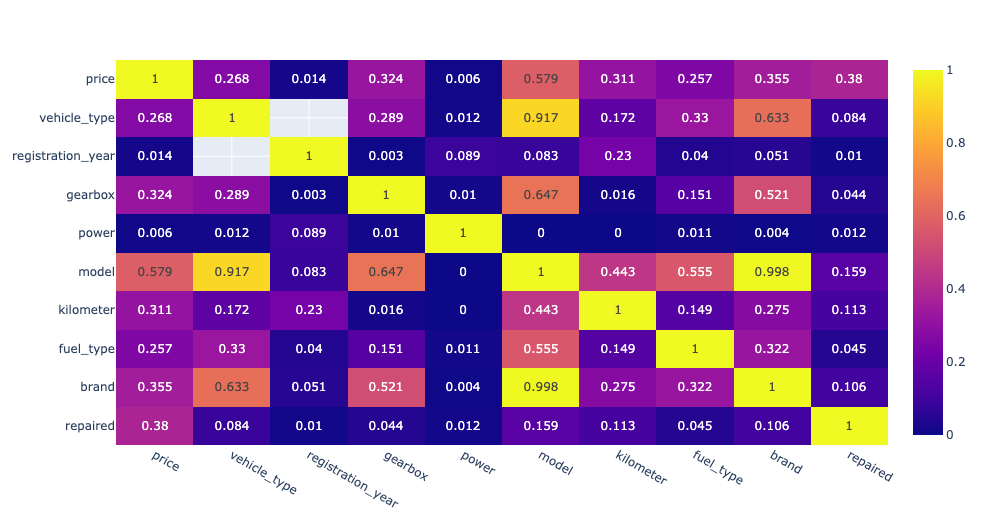

In [15]:
for i in phik_overview:
    print(f'{i}\n')
    print(phik_overview[i].sort_values(ascending=False))
    print('\n\n')

price

price               1.00
model               0.58
repaired            0.38
brand               0.36
gearbox             0.32
kilometer           0.31
vehicle_type        0.27
fuel_type           0.26
registration_year   0.01
power               0.01
Name: price, dtype: float64



vehicle_type

vehicle_type        1.00
model               0.92
brand               0.63
fuel_type           0.33
gearbox             0.29
price               0.27
kilometer           0.17
repaired            0.08
power               0.01
registration_year    NaN
Name: vehicle_type, dtype: float64



registration_year

registration_year   1.00
kilometer           0.23
power               0.09
model               0.08
brand               0.05
fuel_type           0.04
price               0.01
repaired            0.01
gearbox             0.00
vehicle_type         NaN
Name: registration_year, dtype: float64



gearbox

gearbox             1.00
model               0.65
brand               0.52
price         

Видим следующие зависимости:
- Между маркой автомобиля и моделью автомобиля - 0.998;
- Между типом автомобильного кузова и моделью автомобиля - 0.917;
- Между маркой автомобиля и типом коробки передач - 0.647;
- Между типом автомобильного кузова и маркой автомобиля - 0.633;
- Между моделью автомобиля и ценой - 0.579;
- Между моделью автомобиля и типом топлива - 0.555;
- Между маркой автомобиля и типом коробки передач  - 0.521;
- Много зависимостей с коэффициентом 𝜙k около 0.5;

Мы столкнулись с проблемой мультиколлинеарности признаков. Большинство методов устранения мультиколлинеарности предполагает исключение порождающих её признаков. В следующих шагах проверим, улучшится ли качество модели, если удалить один из признаков, то есть проверим модели с мультиколлинеарными признаками и без.

Таргетом является price. Посмотрим на зависимости признаков на цену.

In [16]:
phik_overview['price'].sort_values(ascending=False)

price               1.00
model               0.58
repaired            0.38
brand               0.36
gearbox             0.32
kilometer           0.31
vehicle_type        0.27
fuel_type           0.26
registration_year   0.01
power               0.01
Name: price, dtype: float64

- Прослеживается связь между моделью автомобиля и ценой (model vs price) - 0.58;
- Есть слабая связь между:
  - Была ли машина в ремонте или нет и ценой (repaired vs price) - 0.38;
  - Маркой машины и ценой (brand vs price) - 0.36;
  - Коробкой передач и ценой (gearbox vs price) - 0.32;
  - Пробегом и ценой (kilometer vs price) - 0.31;
  - Типом кузова и ценой (vehicle_type vs price) - 0.27;
  - Типом топлива и ценой (fuel_type vs price) - 0.26;
- Наличие корреляции между фичей и таргетом является плюсом для того, чтобы модель хорошо обучалась;

### 1.2 Посмотрим на уникальные значения, заполним пропуски и удалим аномалии

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [18]:
# Посмотрим на пропуски в процентном соотношении
print('Доля пропусков в столбце:\n', df.isna().mean().sort_values(ascending=False))

Доля пропусков в столбце:
 repaired            0.20
vehicle_type        0.11
fuel_type           0.09
gearbox             0.06
model               0.06
price               0.00
registration_year   0.00
power               0.00
kilometer           0.00
brand               0.00
dtype: float64


In [19]:
# посмотрим на количество уникальных значений для каждого столбца
print('Количество уникальных значений для столбца:')
for column in df:
    print(f'{column}:', df[column].nunique())

Количество уникальных значений для столбца:
price: 3731
vehicle_type: 8
registration_year: 151
gearbox: 2
power: 712
model: 250
kilometer: 13
fuel_type: 7
brand: 40
repaired: 2


In [20]:
list = ['vehicle_type', 'registration_year', 
        'gearbox', 'power', 'model', 
        'kilometer', 'fuel_type', 'brand', 'repaired']

for column in list:
    print(column)
    print(df[column].unique())
    print('\n')

vehicle_type
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


registration_year
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]


gearbox
['manual' 'auto' nan]


power
[    0   190   163    75    69   102   109    50   125   101   105   140
   115   131   

Посмотрим внимательнее на каждый столбец.

Напишем функции, которые будут выводить графики распределения значений.

In [21]:
# для категориальных переменных будем смотреть pie chart
#  и количество уникальных значений
def categorical(column, title):
    #fig = px.pie(df, names=column, title=title)
    #fig.show()
    print(f'Количество уникальных значений для {column}:\n', 
          df[column].value_counts(dropna=False))

In [22]:
# разделим цену на 4 группы (квартили) для удобства анализа
df['price_group'] = pd.qcut(df['price'], q=4)

**1) Тип кузова vehicle_type**

In [23]:
categorical('vehicle_type', 'Тип кузова')

Количество уникальных значений для vehicle_type:
 vehicle_type
sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64


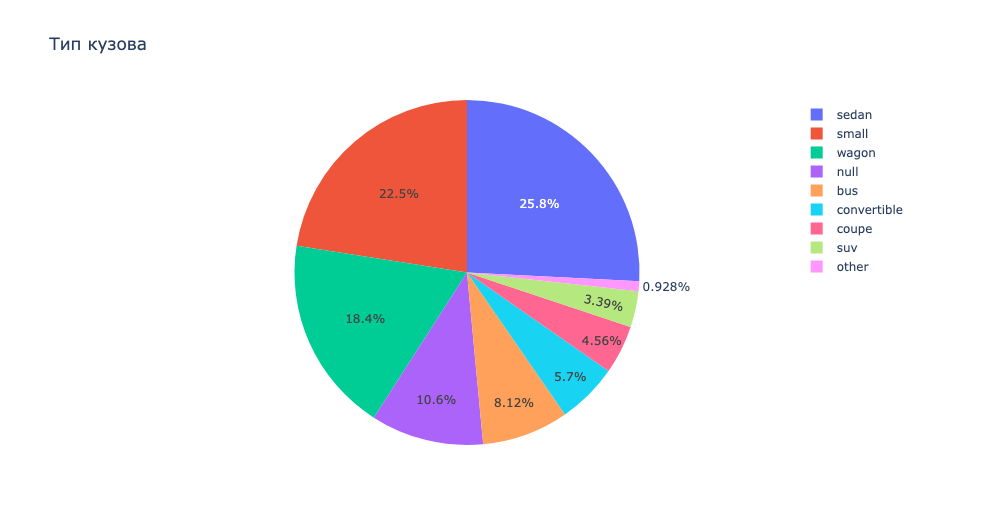

In [ ]:
fig = px.histogram(df, x='vehicle_type', color='price_group',title='Зависимость цены автомобиля от типа кузова', hover_data=df.columns)
fig.show()

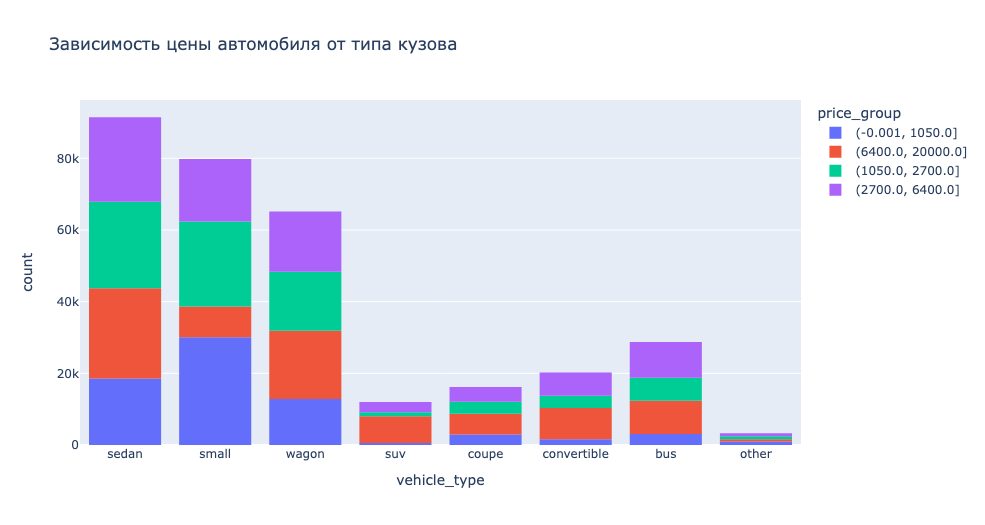

Выводы по типу кузова vehicle_type:
- Популярность типов кузова:
  - Популярнее всего тип кузова sedan - 90870 значений (27%);
  - На втором месте small - 79059 значений (23.5%);
  - На третьем месте wagon - 64683 значений (19.2%);
  - Далее следуют bus (8.49%), convertible (5.95%), coupe (4.76%) и suv (3.54%);
- Мы определили, что коэффициент корреляции 𝜙k между типом кузова и ценой автомобиля равен 0,27, можем проследить следующие зависимости:
  - Автомобили с типом кузова small:
    - Чаще всего стоят до 1199 евро включительно - 31836 значений; 
    - От 1199 до 2899 евро включительно - 22459 значений;
    - От 2899 до 6500 евро включительно - 23932 значений;
    - От 2899 до 6500 евро включительно - 16749 значений;
    - Реже всего от 6500 до 20000 евро включительно - 8015 значений; 
  - Автомобили с типом кузова sedan:
    - Чаще всего стоят от 6500 до 20000 евро включительно - 24210 значений; 
    - От 1199 до 2899 евро включительно - 23932 значений;
    - От 2899 до 6500 евро включительно - 22834 значений;
    - Реже всего от 1199 до 2899 евро включительно - 19894 значений;
  - Автомобили с типом кузова wagon чаще всего стоят до 2000 евро - 23621 значений и от 2000 до 4000 евро - 13793 значений; 
  - В целом цены распределены довольно-таки равномерно;
- У нас 22122 строки (6.58%) с пропусками в типе кузова. Определить тип кузова мы никак не сможем, поэтому заполним пропуски значением моды по модели автомобиля, так как коэффициент корреляции 𝜙k равен 0.917;

In [24]:
df['vehicle_type'] = df['vehicle_type'].fillna(
    df.groupby('model')['vehicle_type'].transform(lambda x: x.value_counts().idxmax()))

In [25]:
df['vehicle_type'].isna().sum()

6828

In [26]:
df['vehicle_type'].value_counts(ascending=False, dropna=False)

vehicle_type
sedan          105772
small           88587
wagon           68535
bus             31882
convertible     20458
coupe           16555
suv             12462
NaN              6828
other            3290
Name: count, dtype: int64

У нас осталось 6828 значений с пропусками. Видимо, для некоторых моделей авто нет моды, поэтому и нет заполнения. Коэффициент корреляции 𝜙k между типом кузова и маркой автомобиля равен 0.633. Заполним оставшиеся пропуски модой по марке автомобиля.

In [27]:
df['vehicle_type'] = df['vehicle_type'].fillna(
    df.groupby('brand')['vehicle_type'].transform(lambda x: x.value_counts().idxmax()))

In [28]:
# проверим успешность заполнения
df['vehicle_type'].value_counts(ascending=False, dropna=False)

vehicle_type
sedan          110130
small           90895
wagon           68636
bus             31906
convertible     20481
coupe           16555
suv             12476
other            3290
Name: count, dtype: int64

Пропуски заполнены.

**2) Тип коробки передач gearbox**

In [29]:
categorical('gearbox', 'Тип коробки передач')

Количество уникальных значений для gearbox:
 gearbox
manual    268251
auto       66285
NaN        19833
Name: count, dtype: int64


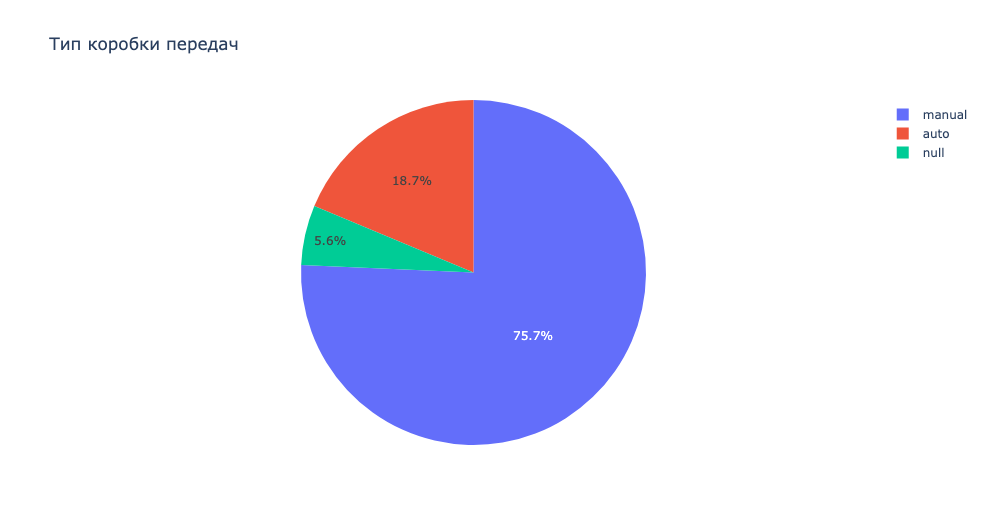

In [ ]:
fig = px.histogram(df, x='gearbox', color='price_group', title='Зависимость цены автомобиля от типа коробки передач', hover_data=df.columns)
fig.show()

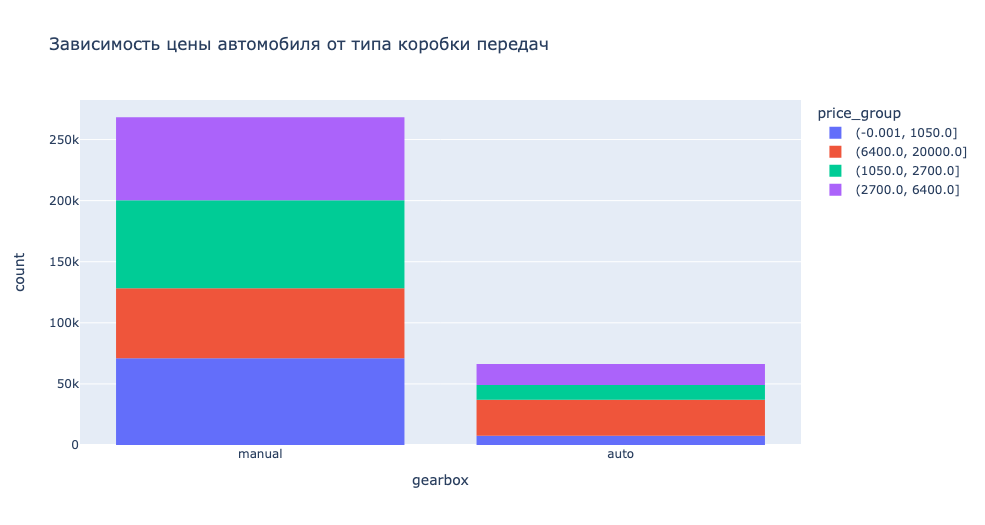

Выводы по типу коробки передач gearbox:
- Популярнее всего механическая коробка передач manual 78%;
- На долю автомата auto приходится 19,4%;
- Для механики цена по группам распределена довольно-таки равномерно;
- Для автомата наиболее часто встречаемой группой является цена от 6500 до 20000 евро (28446 значений);
- Пропуски в данных составляют 2.66% (8954 значения): 
  - У нас есть несколько вариантов заполнения:
    - Заполнить модой;
    - Заполнить значением unknown;
    - Дропнуть эти значения;
  - Заполним модой по модели автомобиля, так как коэффициент корреляции 𝜙k равен 0.647;

In [30]:
df['gearbox'] = df['gearbox'].fillna(
    df.groupby('model')['gearbox'].transform(lambda x: x.value_counts().idxmax()))

In [31]:
df['gearbox'].value_counts(ascending=False, dropna=False)

gearbox
manual    282238
auto       68000
NaN         4131
Name: count, dtype: int64

Оставшиеся пропуски заполним модой по марке автомобиля (коэффициент корреляции 𝜙k равен 0.521).

In [32]:
df['gearbox'] = df['gearbox'].fillna(
    df.groupby('brand')['gearbox'].transform(lambda x: x.value_counts().idxmax()))

In [33]:
# проверим успешность
df['gearbox'].value_counts(ascending=False, dropna=False)

gearbox
manual    286057
auto       68312
Name: count, dtype: int64

**3) Модель автомобиля model**

In [34]:
df['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [35]:
# заполним пропуски модой по марке автомобиля
df['model'] = df['model'].fillna(
    df.groupby('brand')['gearbox'].transform(lambda x: x.value_counts().idxmax()))

In [36]:
# проверим успешность заполнения
df['model'].isna().sum()

0

Выводы по модели автомобимля model:
- Пропуски в данных составляли 6% (19705 значений), заполнили пропуски модой по модели автомобиля; 

**4) Тип топлива fuel_type**

In [37]:
categorical('fuel_type', 'Тип топлива')

Количество уникальных значений для fuel_type:
 fuel_type
petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64


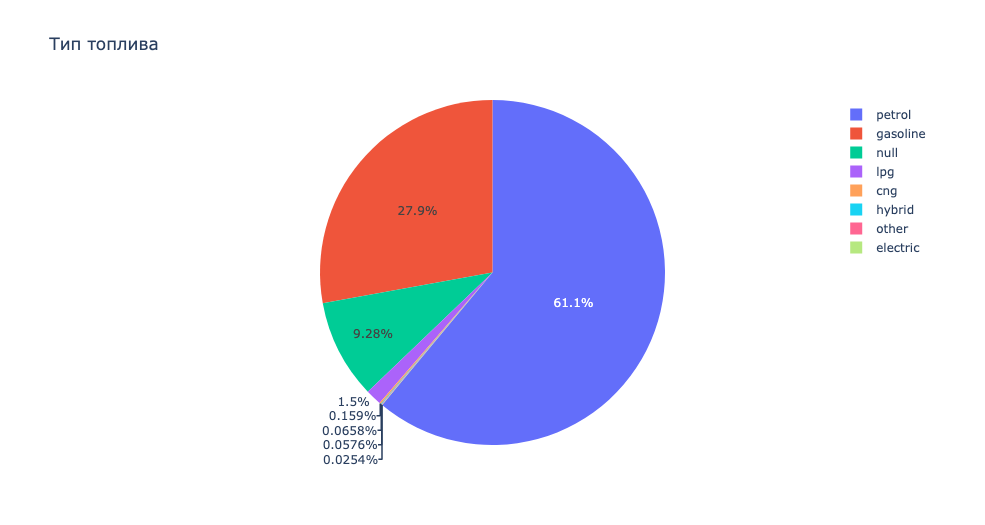

Объединим значения petrol и gasoline, так как это все бензин, просто по-разному обозначается в разных странах. При этом lpg и cng - газы, но у них разный способ получения: cng - это метан, lpg содержит более тяжелые фракции (пропан, бутан). Поэтому их объединять не будем.

In [38]:
df['fuel_type'] = df['fuel_type'].replace(['gasoline'],'petrol')

In [39]:
categorical('fuel_type', 'Тип топлива')

Количество уникальных значений для fuel_type:
 fuel_type
petrol      315072
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64


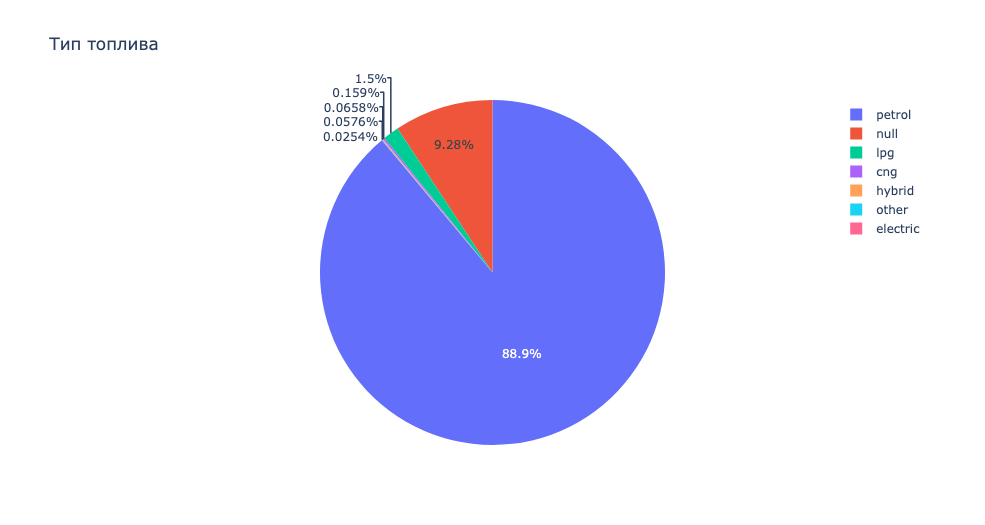

In [ ]:
fig = px.histogram(df, x='fuel_type', 
                   color='price_group', 
                   title='Зависимость цены автомобиля от типа топлива', 
                   hover_data=df.columns)
fig.show()

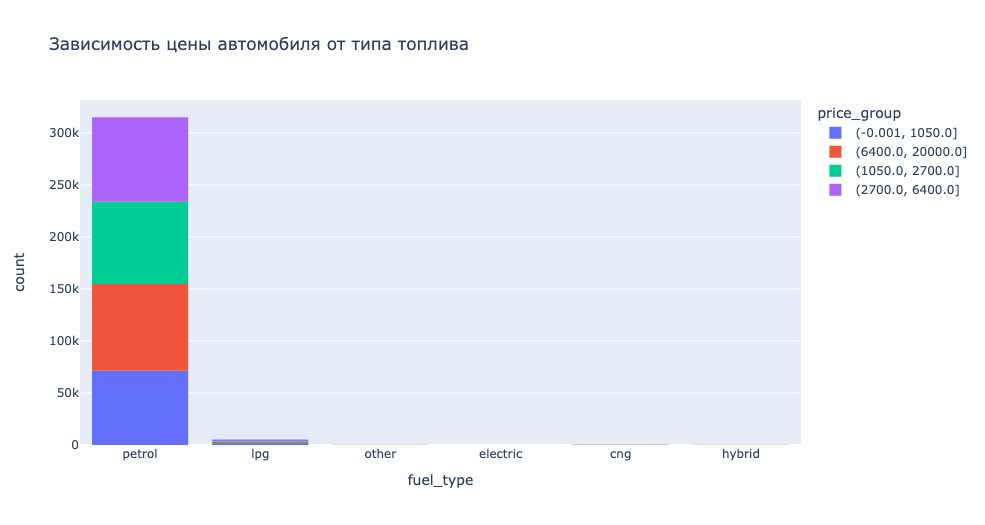

Выводы по типу топлива fuel_type:
- Объединили значения petrol и gasoline, так как это обозначение бензина в разных странах;
- Чаще всего используют бензиновые типы двигателей - 92.6%;
- Далее идет с большим отрывом смесь пропана и бутана lpg - 1.56%;
- У других типов топлива совсем незначительные цифры (видимо, причина в том, что данные за 2016 год и много старых автомобилей, ставку на экологичность еще не делали);
- Цена автомобиля в зависимости от типа топлива распределена равномерно, видно лишь, что стоимость гибридных автомобилей чаще всего составляет выше 6500 евро;
- Пропуски составляют 5.51% (18540 значений), заполним модой по модели автомобиля (коэффициент phik равен 0.555);

In [40]:
df['fuel_type'] = df['fuel_type'].fillna(
    df.groupby('model')['fuel_type'].transform(lambda x: x.value_counts().idxmax()))

In [41]:
# проверим успешность заполнения
df['fuel_type'].value_counts(ascending=False, dropna=False)

fuel_type
petrol      347967
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

**5) Была машина в ремонте или нет - repaired**

In [42]:
categorical('repaired', 'Была машина в ремонте или нет')

Количество уникальных значений для repaired:
 repaired
no     247161
NaN     71154
yes     36054
Name: count, dtype: int64


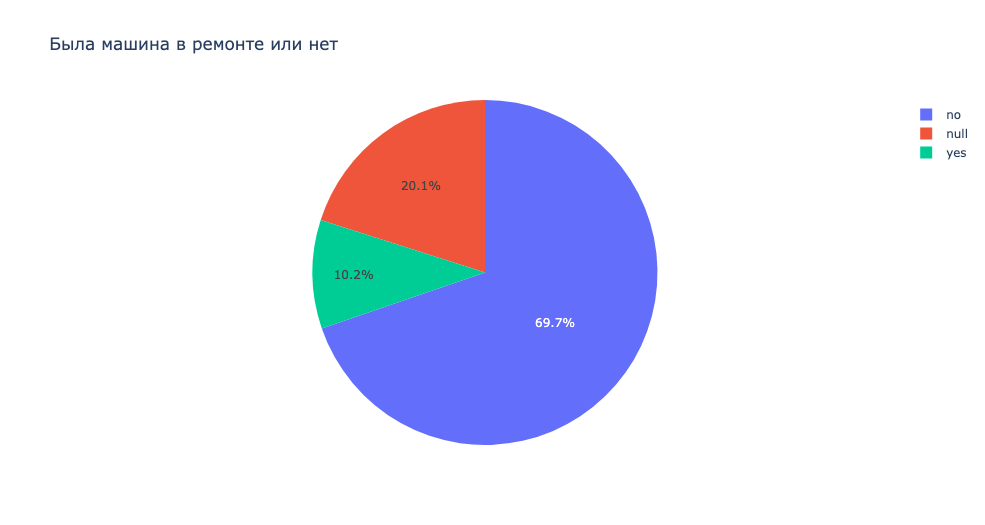

In [ ]:
fig = px.histogram(df, x='repaired', 
                   color='price_group', 
                   title='Зависимость цены автомобиля от того, был ли автомобиль в ремонте',  
                   hover_data=df.columns)
fig.show()

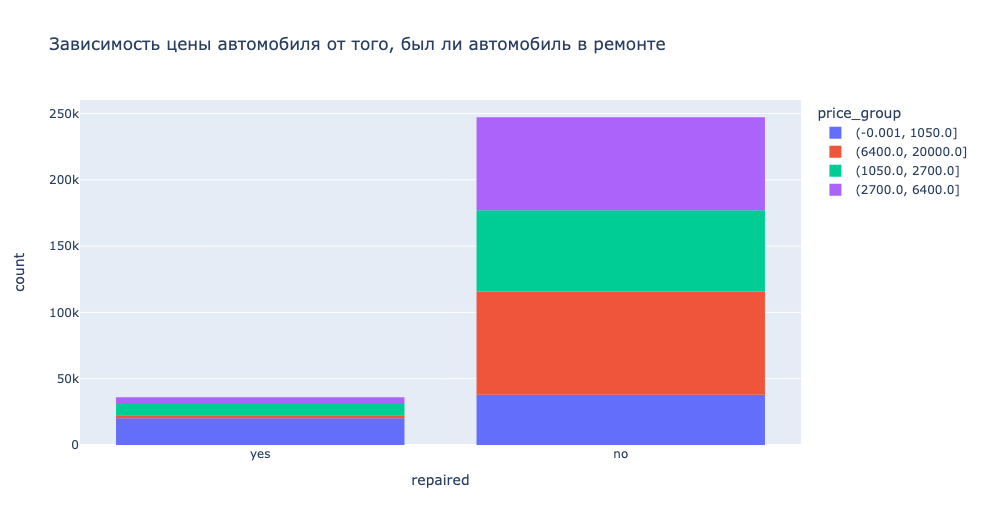

Выводы по ремонту автомобилей:
- Чаще всего автомобиль не был в ремонте -  73.1%;
- Был в ремонте в 10.6% случаев;
- Зависимость цены от факта ремонта автомобиля:
  - Цена распределена равномерно среди автомобилей, не бывших в ремонте;
  - Автомобили, бывшие в ремонте чаще всего стоят до 1199 евро и до 2899 евро;
- Имеем 16.4% пропусков (55104 значения). Предположим, что раз факт ремонта не указан, то его не было. Заполним пропуски значением no;

In [43]:
df['repaired'] = df['repaired'].fillna('no')

In [44]:
# проверим успешность заполнения
df['repaired'].value_counts(ascending=False, dropna=False)

repaired
no     318315
yes     36054
Name: count, dtype: int64

**6) Год регистрации автомобиля registration_year**

In [45]:
df['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [46]:
df['registration_year'].value_counts(ascending=False)

registration_year
2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
2003    19763
2004    19611
2002    19092
1998    17899
2007    17183
2008    15391
1997    14666
2009    14503
1996    10835
2010    10764
2017    10441
2011     9909
1995     9607
2016     9599
2012     7178
1994     4841
2013     4131
2018     3959
1993     3438
1992     3002
1990     2806
1991     2762
2014     2537
1989     1318
2015     1302
1988      942
1985      756
1987      667
1980      588
1986      538
1983      430
1984      399
1970      333
1982      316
1978      285
1979      283
1981      263
1972      213
1960      188
1976      175
1977      173
1973      173
1974      169
1971      167
1975      143
1969      118
1966      113
1968      108
1910      101
1967       99
1965       82
1964       64
1963       57
1962       46
1961       41
1000       37
1959       32
1956       27
9999       26
1958       25
2019       25
1950       18
5000       17
1955       15
1953       14
19

В годе регистрации автомобиля видны аномалии: мы имеем данные за 2016 год, поэтому год регистрации не может быть больше 2016. Первый в мире серийный автомобиль появился в 1885 году, все, что раньше - аномалии. Так же хочу заметить, что по ГОСТ от 01.03.2020 раритетным является автомобиль, с момента производства которого прошло больше 30 лет. Цену раритетного автомобиля очень сложно предсказать, поэтому удалим также все автомобили старше 1970 года (формально необходимо было бы старше 1986 года, но мы потеряем большое число данных).

In [47]:
print('Количество объявлений с годом регистрации авто старше 2016 и младше 1970:', 
      len(df.loc[(df['registration_year'] > 2016) | (df['registration_year'] < 1970)]))

Количество объявлений с годом регистрации авто старше 2016 и младше 1970: 15868


In [48]:
print(f'Доля объявлений с годом регистрации авто старше 2016 и младше 1970:', 
      (len(df.loc[(df['registration_year'] > 2016) | (df['registration_year'] < 1970)]) / len(df))*100, '%')

Доля объявлений с годом регистрации авто старше 2016 и младше 1970: 4.477818319322514 %


Удалим 15868 записей - 4,48% данных.

In [49]:
df = df.loc[(df['registration_year'] <= 2016) & (df['registration_year'] >= 1970)].copy()

In [50]:
# проверим
df['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 2016,
       2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982,
       1976, 1983, 1973, 1971, 1987, 1986, 1988, 1970, 1974, 1979, 1978,
       1972, 1977, 1975])

**7) Мощность в лошадиных силах - power**

In [ ]:
fig = px.histogram(
    df, x='power', 
    title='Мощность в лошадиных силах', 
    marginal='box'
)
fig.show()

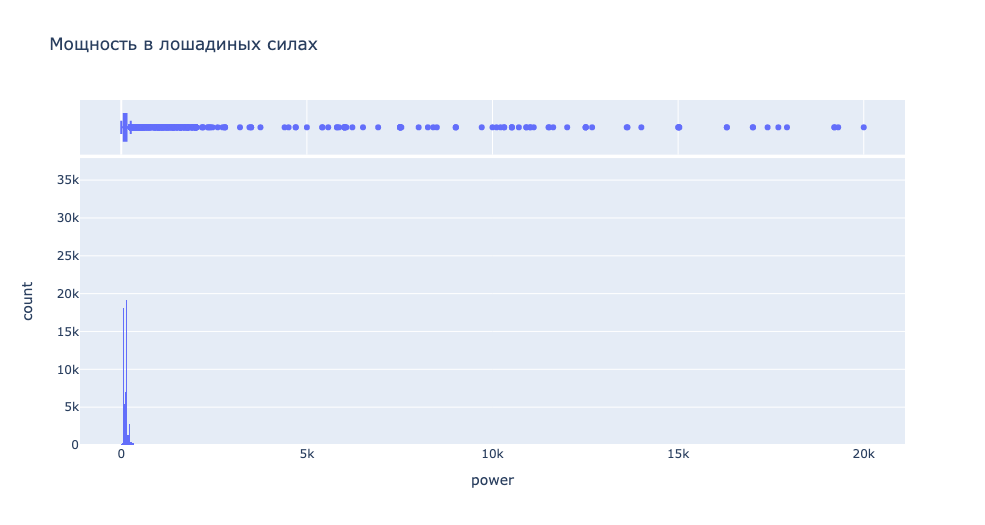

In [ ]:
fig = px.histogram(
    df, x='power', 
    title='Мощность в лошадиных силах промасштабированно', 
    marginal="box"
)
fig.update_layout(xaxis_range=[0, 600])
fig.show()

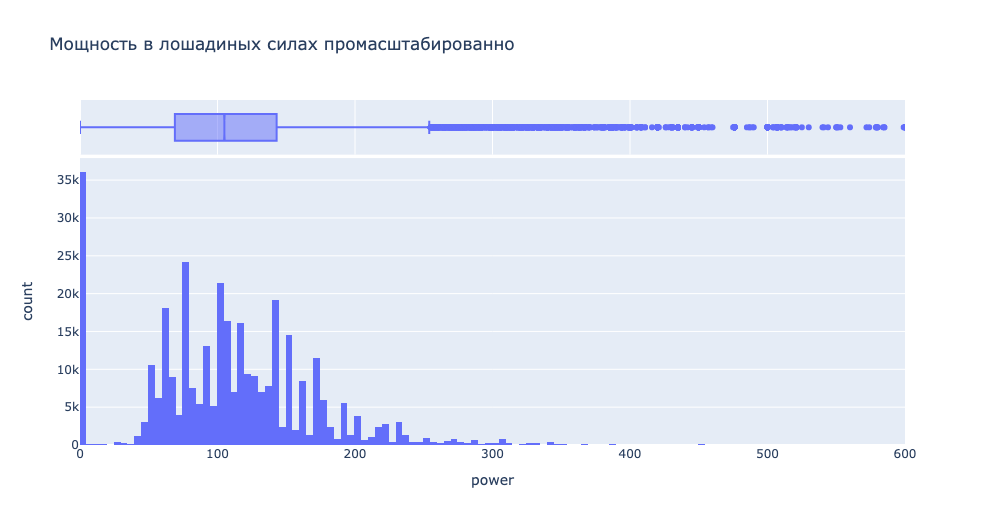

Видим очень много выбросов. Самым мощным автомобилем в мире является Dagger GT - 2028 лс. У нас представлены легковые автомобили и автобусы. Самым мощным автобусом является Mercedes-Benz Citaro G - до 480 лс.

Также видим большой выброс в районе 0.

In [51]:
print('Количество автомобилей с мощностью меньше или равной 0:', 
      len(df[df['power'] <= 0]))

Количество автомобилей с мощностью меньше или равной 0: 35934


Удалять такое количество строк нецелесообразно, поэтому заменим нулевые значения медианой по модели. Также  избавимся от автомобилей мощностью более 1000 л.с (275 значений).

In [52]:
print('Количество автомобилей мощностью более 1000 л.с.:', 
      df.loc[df['power'] > 1000].count().mean())

Количество автомобилей мощностью более 1000 л.с.: 275.0


In [53]:
df.loc[(df['power'] <= 0)] = None
df['power'] = df['power'].fillna(df.groupby('model')['power'].transform('median'))
df = df[~df['power'].isna()]
df['power'] = df['power'].astype('int64')

In [54]:
df = df.loc[df['power'] < 1000].copy()

In [ ]:
fig = px.histogram(
    df, x='power', 
    title='Мощность в лошадиных силах', 
    marginal='box'
)
fig.show()

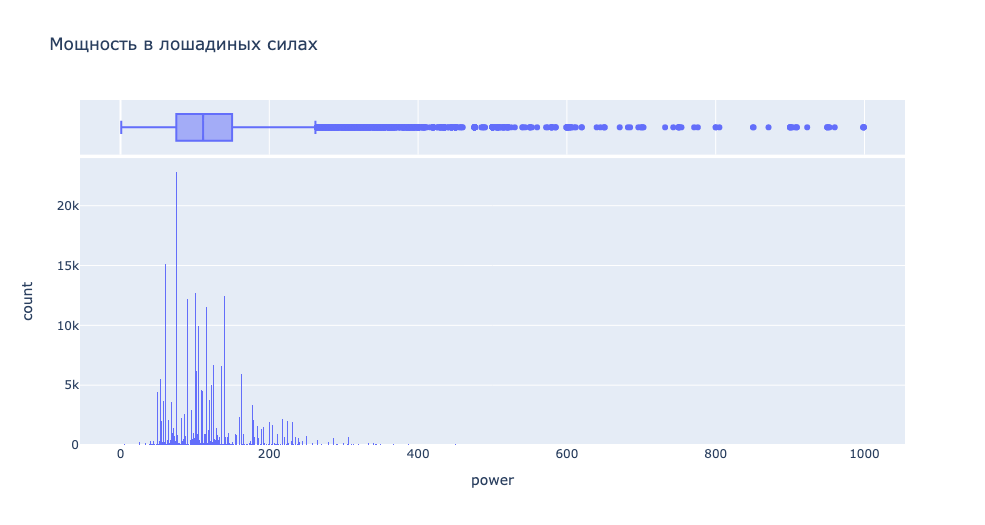

**8) Пробег в километрах - kilometer**

In [ ]:
fig = px.histogram(
    df, x='kilometer', 
    title='Пробег в километрах', 
    marginal='box'
)
fig.show()

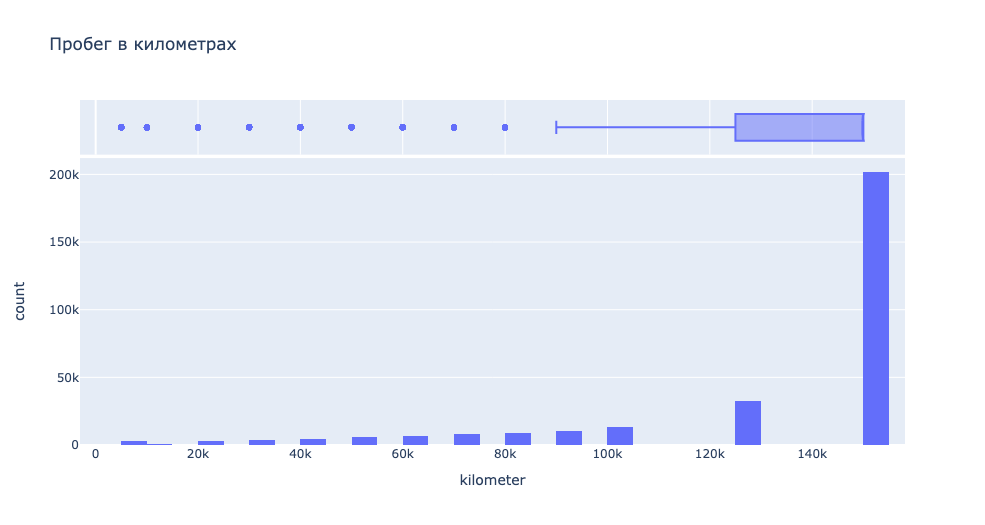

В целом все хорошо, аномалий нет. Данные выглядят немного синтетическими, т.к. пики на значениях, кратных 10 тыс. Возможно, при внесении данных их округляли.

In [ ]:
fig = px.histogram(
    df, x='kilometer', 
    color='price_group', 
    title='Зависимость цены автомобиля от пробега', 
    hover_data=df.columns
)
fig.show()

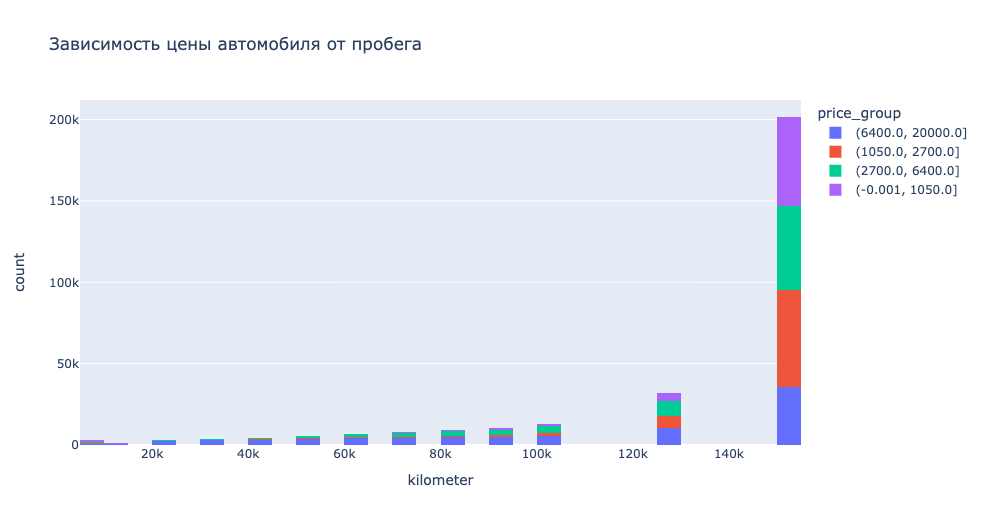

**9) Марка автомобиля - brand**

In [56]:
brand = df['brand'].value_counts(ascending=False)

In [ ]:
fig = px.bar(brand, text_auto='.2s', title='Марка автомобиля')
fig.update_layout(xaxis_title='brand', yaxis_title='count')
fig.update_traces(
    textfont_size=12, 
    textangle=0, 
    textposition="outside", 
    cliponaxis=False
)
fig.show()

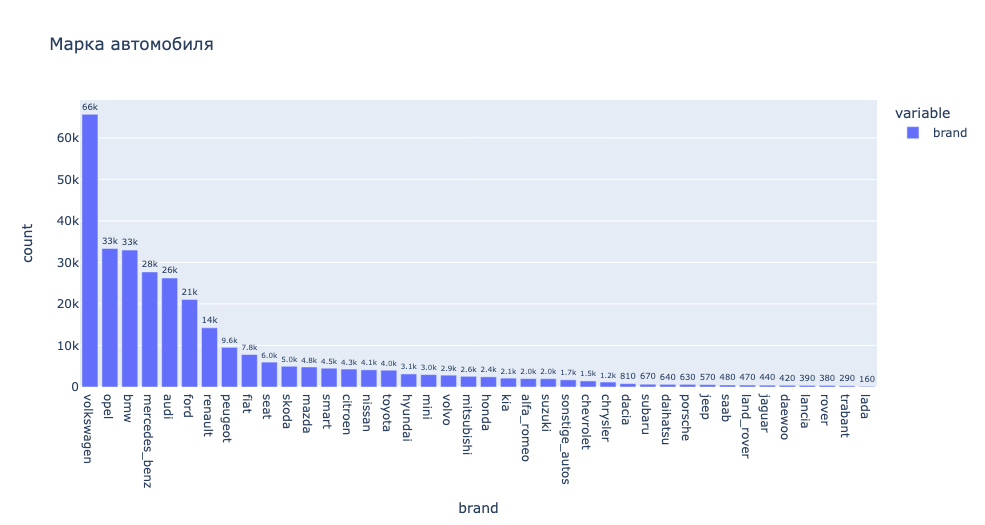

In [57]:
categorical('brand', 'Марка автомобиля')

Количество уникальных значений для brand:
 brand
volkswagen        65665
opel              33355
bmw               32966
mercedes_benz     27713
audi              26243
ford              21062
renault           14254
peugeot            9550
fiat               7817
seat               5990
skoda              4990
mazda              4814
smart              4522
citroen            4319
nissan             4127
toyota             4046
hyundai            3142
mini               2984
volvo              2852
mitsubishi         2567
honda              2440
kia                2131
alfa_romeo         2019
suzuki             1999
sonstige_autos     1727
chevrolet          1459
chrysler           1196
dacia               806
subaru              666
daihatsu            638
porsche             632
jeep                570
saab                482
land_rover          468
jaguar              442
daewoo              415
lancia              391
rover               384
trabant             285
lada           

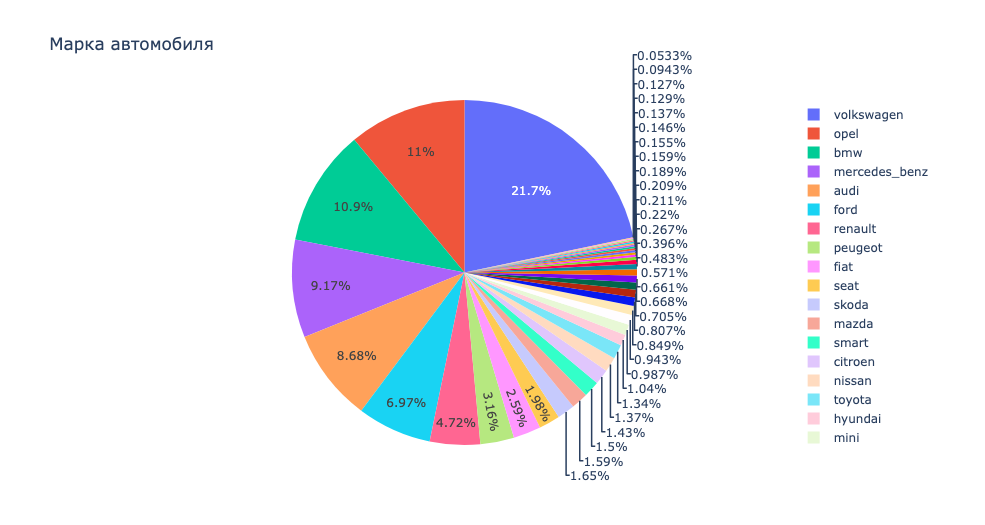

Выводы по марке автомобиля:
- Наиболее популярной маркой автомобиля является Volkswagen - 21.6% (64300);
- На втором месте opel - 11% (32658) и bmw - 10.9% (32508);
- Далее идет mercedes_benz - 9.24% (27451);
- Audi - 8.7% (25856);
- Можно сделать вывод, что наиболее популярными являются немецкие автомобили;

**10) Цена автомобиля в евро - price**

In [ ]:
fig = px.histogram(df, x='price',
                   title='Цена автомобиля в евро', 
                   marginal='box')
fig.update_layout(bargap=0.2)
fig.show()

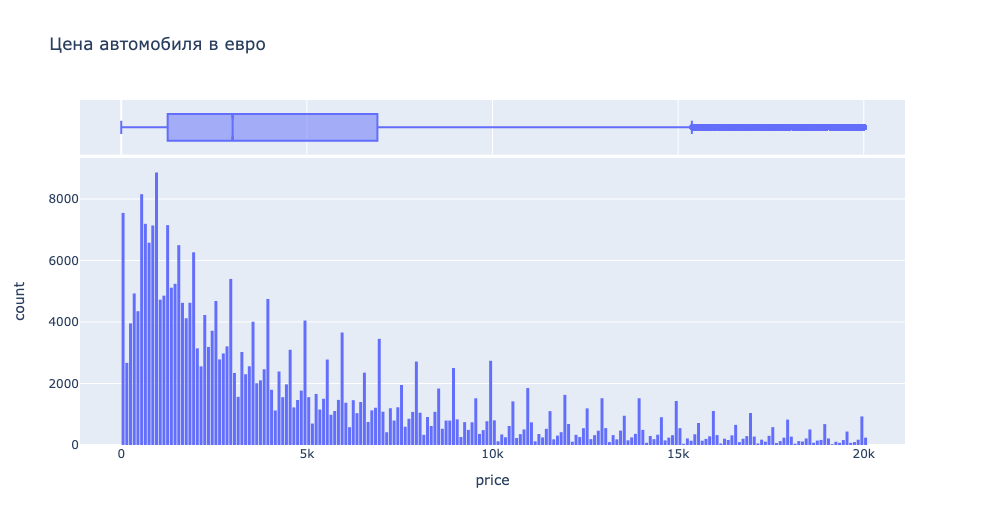

По гистограмме видим выбросы в районе нуля. Так как price является целевым признаком (таргетом), то я не вижу смысла заполнять эти значения. Заполнение может быть некорректным и может отрицательно повлиять на прогноз модели. 

In [58]:
print("Количество автомобилей с ценой равной 0:", len(df[df['price'] == 0]))

Количество автомобилей с ценой равной 0: 6374


In [59]:
# Удалим эти объявления
df = df[df['price'] != 0]

In [60]:
# Проверим
print("Количество автомобилей с ценой равной 0:", 
      len(df[df['price'] == 0]))

Количество автомобилей с ценой равной 0: 0


**Посмотрим на явные дубликаты**

In [61]:
print('Количество явных дубликатов:', 
      df.duplicated().sum())

Количество явных дубликатов: 49683


In [62]:
df = df.drop_duplicates().reset_index(drop=True)

In [63]:
print('Количество явных дубликатов:', 
      df.duplicated().sum())

Количество явных дубликатов: 0


In [64]:
# Удалим столбец price_group, он нам больше не нужен
df.drop(columns=['price_group'], axis=1, inplace=True)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246232 entries, 0 to 246231
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              246232 non-null  float64
 1   vehicle_type       246232 non-null  object 
 2   registration_year  246232 non-null  float64
 3   gearbox            246232 non-null  object 
 4   power              246232 non-null  int64  
 5   model              246232 non-null  object 
 6   kilometer          246232 non-null  float64
 7   fuel_type          246232 non-null  object 
 8   brand              246232 non-null  object 
 9   repaired           246232 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 18.8+ MB


### Выводы по шагу 1
- В датафрейме:
  - 354369 строк;
  - 16 столбцов;
  - Есть пропуски;
  - Типы данных в столбцах не требуют преобразований;
  - Перед нами стоит задача регрессии: определение рыночной стоимости автомобиля (таргет price);
- Удалили признаки, не влияющие на прогнозирование цены авто:
  - date_crawled — дата скачивания анкеты из базы
  - date_created — дата создания анкеты
  - number_of_pictures — количество фотографий автомобиля
  - postal_code — почтовый индекс владельца анкеты (пользователя)
  - last_seen — дата последней активности пользователя
- Сделали следующие выводы по признакам:
  - Цена:
    - Минимальная цена автомобиля - 0 евро, что равносильно пропуску;
    - Максимальная цена - 20000 евро;
    - Медианная цена - 2700 евро;
    - Средняя цена - 4417 евро, что означает, что есть какие-то дорогие автомобили, влияющие на характеристику среднего;
  - Год регистрации автомобиля:
    - Есть аномалии:
      - Минимальный год регистрации - 1000;
      - Максимальный год - 9999;
    - Среднее (2004) и медианное (2003) значения практически совпадают;
    - 75% автомобилей зарегистрированы до 2008 года;
  - Мощность:
    - Минимальная мощность - 0 л.с. (равносильно пропуску);
    - Средняя мощность - 110 л.с.;
    - 50% автомобилей имеют мощность до 105 л.с. (среднее и медиана практически равны);
    - Максимальная мощность - 20000 л.с. (аномалия);
  - Пробег:
    - Минимальный пробег - 5000 км;
    - Максимальный - 150000 км;
    - Средний пробег - 128211 км;
    - Медианный - 150000 км;
  - Месяц регистрации автомобиля:
    - Минимальный месяц регистрации - 0 (аномалия, равносильно пропуску);
    - Максимальный месяц регистрации - 12 (без аномалий);
    - В целом распределение выглядит нормальным - 50%/в среднем автомобили зарегистрированы в первой половине года (необходимо посмотреть на распределение);
  - Количество фотографий автомобиля:
    - Фотографии отсутствуют во всех объявлениях, признак неинформативен;
- В данных есть пропуски:
  - Больше всего пропусков в столбце repaired - 20% (71154 значения);
  - Далее идет столбец vehicle_type - 11% (37490 значений);
  - Столбец fuel_type - 9% (32895);
  - Столбцы gearbox (19833) и model (19705) по 6%;
  - В остальных столбцах пропуски отсутствуют;
- Проверили корреляцию признаков при помощи коэффициента 𝜙k:
  - Увидели следующие зависимости:
    - Между маркой автомобиля и моделью автомобиля - 0.998;
    - Между типом автомобильного кузова и моделью автомобиля - 0.917;
    - Между маркой автомобиля и типом коробки передач - 0.647;
    - Между типом автомобильного кузова и маркой автомобиля - 0.633;
    - Между моделью автомобиля и ценой - 0.579;
    - Между моделью автомобиля и типом топлива - 0.555;
    - Между маркой автомобиля и типом коробки передач  - 0.521;
    - Много зависимостей с коэффициентом 𝜙k около 0.5;
    - Проверили зависимость таргета от фичей, выяснили:
      - Прослеживается связь между моделью автомобиля и ценой (model vs price) - 0.58;
      - Есть слабая связь между:
        - Была ли машина в ремонте или нет и ценой (repaired vs price) - 0.38;
        - Маркой машины и ценой (brand vs price) - 0.36;
        - Коробкой передач и ценой (gearbox vs price) - 0.32;
        - Пробегом и ценой (kilometer vs price) - 0.31;
        - Типом кузова и ценой (vehicle_type vs price) - 0.27;
        - Типом топлива и ценой (fuel_type vs price) - 0.26;
      - Наличие корреляции между фичей и таргетом является плюсом для того, чтобы модель хорошо обучалась;
  - Выяснили, что столкнулись с проблемой мультиколлинеарности признаков. Большинство методов устранения мультиколлинеарности предполагает исключение порождающих её признаков. В следующих шагах проверим, улучшится ли качество модели, если удалить один из признаков, то есть проверим модели с мультиколлинеарными признаками и без;
- Подробно рассмотрели признаки, устранили пропуски и аномалии, сделали следующие выводы:
  - Выводы по типу кузова vehicle_type:
    - Популярность типов кузова:
      - Популярнее всего тип кузова sedan - 90870 значений (27%);
      - На втором месте small - 79059 значений (23.5%);
      - На третьем месте wagon - 64683 значений (19.2%);
      - Далее следуют bus (8.49%), convertible (5.95%), coupe (4.76%) и suv (3.54%);
  - Мы определили, что коэффициент корреляции 𝜙k между типом кузова и ценой автомобиля равен 0,27, можем проследить следующие зависимости:
    - Автомобили с типом кузова small:
      - Чаще всего стоят до 1199 евро включительно - 31836 значений; 
      - От 1199 до 2899 евро включительно - 22459 значений;
      - От 2899 до 6500 евро включительно - 23932 значений;
      - От 2899 до 6500 евро включительно - 16749 значений;
      - Реже всего от 6500 до 20000 евро включительно - 8015 значений; 
    - Автомобили с типом кузова sedan:
      - Чаще всего стоят от 6500 до 20000 евро включительно - 24210 значений; 
      - От 1199 до 2899 евро включительно - 23932 значений;
      - От 2899 до 6500 евро включительно - 22834 значений;
      - Реже всего от 1199 до 2899 евро включительно - 19894 значений;
    - Автомобили с типом кузова wagon чаще всего стоят до 2000 евро - 23621 значений и от 2000 до 4000 евро - 13793 значений; 
    - В целом цены распределены довольно-таки равномерно;
  - У нас 22122 строки (6.58%) с пропусками в типе кузова. Определить тип кузова мы никак не сможем, поэтому заполнили пропуски значением моды по модели автомобиля, так как коэффициент корреляции 𝜙k равен 0.917:
    - После заполнения осталось 6828 значений с пропусками. Можем сделать вывод, что для некоторых моделей авто нет моды, поэтому и нет заполнения. Коэффициент корреляции 𝜙k между типом кузова и маркой автомобиля равен 0.633. Заполнили оставшиеся пропуски модой по марке автомобиля;
  - Выводы по типу коробки передач gearbox:
    - Популярнее всего механическая коробка передач manual 78%;
    - На долю автомата auto приходится 19,4%;
    - Для механики цена по группам распределена довольно-таки равномерно;
    - Для автомата наиболее часто встречаемой группой является цена от 6500 до 20000 евро (28446 значений);
    - Пропуски в данных составляют 2.66% (8954 значения), заполнили модой по модели автомобиля, так как коэффициент корреляции 𝜙k равен 0.647 и после оставшиеся пропуски заполнили модой по марке автомобиля (коэффициент корреляции 𝜙k равен 0.521);
  - Выводы по модели автомобимля model:
    - Пропуски в данных составляли 6% (19705 згначений), заполнили пропуски модой по модели автомобиля; 
  - Выводы по типу топлива fuel_type:
    - Объединили значения petrol и gasoline, так как это обозначение бензина в разных странах;
    - Чаще всего используют бензиновые типы двигателей - 92.6%;
    - Далее идет с большим отрывом смесь пропана и бутана lpg - 1.56%;
    - У других типов топлива совсем незначительные цифры (видимо, причина в том, что данные за 2016 год и много старых автомобилей, ставку на экологичность еще не делали);
    - Цена автомобиля в зависимости от типа топлива распределена равномерно, видно лишь, что стоимость гибридных автомобилей чаще всего составляет выше 6500 евро;
    - Пропуски составляли 5.51% (18540 значений), заполнили модой по модели автомобиля (коэффициент phik равен 0.555);
  - Выводы по ремонту автомобилей:
    - Чаще всего автомобиль не был в ремонте -  73.1%;
    - Был в ремонте в 10.6% случаев;
    - Зависимость цены от факта ремонта автомобиля:
      - Цена распределена равномерно среди автомобилей, не бывших в ремонте;
      - Автомобили, бывшие в ремонте чаще всего стоят до 1199 евро и до 2899 евро;
    - Пропуски составляли 16.4% (55104 значения). Предположили, что раз факт ремонта не указан, то его не было. Заполнили пропуски значением no;
  - Выводы по году регистрации автомобиля:
     - В годе регистрации автомобиля были видны аномалии: 
       - Удалили автомобили с годом регистрации позже 2016, так как мы имеем данные за 2016 год, то год регистрации не может быть больше 2016.
       - Удалили также все автомобили старше 1970 года, так как:
         - Первый в мире серийный автомобиль появился в 1885 году, все, что раньше - аномалии; 
         - По ГОСТ от 01.03.2020 раритетным является автомобиль, с момента производства которого прошло больше 30 лет. Цену раритетного автомобиля очень сложно предсказать;
  - Выводы по мощности автомобиля в лс:
    - В данных было много аномалий:
      - Удалили автомобили мощностью более 1000 л.с (275 значений), так как самым мощным автомобилем в мире является Dagger GT - 2028 лс. У нас представлены легковые автомобили и автобусы. Самым мощным автобусом является Mercedes-Benz Citaro G - до 480 лс. Цену тюнингованных автомобилей также сложно предсказать.
      - Заменили значения мощности равное 0 (35934 значений) медианой по модели;
  - Выводы по пробегу автомобиля в километрах:
    - Аномалий не было выявлено. Данные выглядят немного синтетическими, т.к. пики на значениях, кратных 10 тыс. Возможно, при внесении данных их округляли;
  - Выводы по марке автомобиля:
    - Наиболее популярной маркой автомобиля является Volkswagen - 21.6% (64300);
    - На втором месте opel - 11% (32658) и bmw - 10.9% (32508);
    - Далее идет mercedes_benz - 9.24% (27451);
    - Audi - 8.7% (25856);
    - Можно сделать вывод, что наиболее популярными являются немецкие автомобили;
  - Выводы по цене автомобиля в евро:
    - Удалили автомобили с ценой равной 0 (6374 значения), так как price является целевым признаком (таргетом) и заполнение может быть некорректным и может отрицательно повлиять на прогноз модели;
- Обнаружили 49683 явных дубликата и удалили их;

## 2 Подготовка данных для машинного обучения

Как ранее выяснили, у нас существует проблема мультиколлинеарности признаков. В связи с этим будем обучать модели как на данных с мультиколлинеарными признаками, так и без. Во втором случае удалим признак model, так как он имеет наибольшее количество корреляций с другими признаками (коэффициент 𝜙k).

In [66]:
phik_overview['model'].sort_values(ascending=False)

model               1.00
brand               1.00
vehicle_type        0.92
gearbox             0.65
price               0.58
fuel_type           0.55
kilometer           0.44
repaired            0.16
registration_year   0.08
power               0.00
Name: model, dtype: float64

Выделим фичи и таргет.

In [67]:
# фичи мультиколлинеарные
features_mc = df.drop('price', axis=1) 

# фичи немультиколлинеарные
features_non_mc = df.drop(['price', 'model'], axis=1) 

# таргет
target = df['price'] 

### 2.1 Разделение данных на выборки

In [68]:
features_mc_train, features_mc_test, target_train, target_test = train_test_split(features_mc, 
                                                                            target, 
                                                                            test_size=0.2, 
                                                                            random_state=RANDOM)

In [69]:
features_nmc_train, features_nmc_test, target_train, target_test = train_test_split(features_non_mc, 
                                                                            target, 
                                                                            test_size=0.2, 
                                                                            random_state=RANDOM)

In [70]:
print('Признаки обучающей мультиколлинеарной выборки:',features_mc_train.shape,
      '\nПризнаки обучающей немультиколлинеарной выборки:',features_nmc_train.shape,
      '\nЦелевой признак обучающей выборки:', target_train.shape[0], 
      '\nПризнаки тестовой мультиколлинеарной выборки:', features_mc_test.shape,
      '\nПризнаки тестовой немультиколлинеарной выборки:', features_nmc_test.shape,
     '\nЦелевой признак тестовой выборки:', target_test.shape[0])

Признаки обучающей мультиколлинеарной выборки: (196985, 9) 
Признаки обучающей немультиколлинеарной выборки: (196985, 8) 
Целевой признак обучающей выборки: 196985 
Признаки тестовой мультиколлинеарной выборки: (49247, 9) 
Признаки тестовой немультиколлинеарной выборки: (49247, 8) 
Целевой признак тестовой выборки: 49247


### 2.2 Кодировка категориальных признаков

Для кодирования категориальных признаков будем использовать OHE из sklearn. Дело в том, `get_dummies` подходит для анализа данных, а для машинного обучения более предпочтителен `OHE`, т.к. он позоволяет избежать ряд ошибок при обучении моделей, в том числе может работать с неизвестными ранее уровнями категорий, которых не было изначально (например, если появится еще один тип топлива).

In [71]:
# список категориальных признаков с мультиколлинеарностью
cat_mc = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# список категориальных признаков без мультиколлинеарности
cat_nmc = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']

# список численных признаков
num = ['registration_year', 'power', 'kilometer']

In [72]:
# закодируем категориальные признаки с мультиколлинеарностью
oh = OneHotEncoder(sparse=False, handle_unknown='ignore')

ar_tr = oh.fit_transform(features_mc_train[cat_mc])
ar_ts = oh.transform(features_mc_test[cat_mc])

features_mc_train = pd.concat([features_mc_train[num], 
                pd.DataFrame(ar_tr, columns=oh.get_feature_names_out(cat_mc), 
                             index=features_mc_train.index)], axis= 1)

features_mc_test = pd.concat([features_mc_test[num], 
                pd.DataFrame(ar_ts, columns=oh.get_feature_names_out(cat_mc), 
                             index=features_mc_test.index)], axis= 1)

display(features_mc_train)
display(features_mc_test)

,registration_year,power,kilometer,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_yes
17895,"2,007.00",218,"150,000.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
10670,"2,009.00",90,"60,000.00",0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
223971,"2,006.00",110,"150,000.00",1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
128300,"2,011.00",105,"80,000.00",0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
147705,"1,998.00",193,"150,000.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85412,"2,000.00",101,"150,000.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
133249,"2,005.00",145,"150,000.00",1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
130333,"2,007.00",136,"150,000.00",1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
77285,"2,008.00",143,"150,000.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


,registration_year,power,kilometer,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_yes
52070,"2,011.00",86,"30,000.00",0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
58569,"2,004.00",140,"150,000.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
46774,"1,986.00",125,"30,000.00",0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
244765,"2,001.00",105,"125,000.00",0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
58804,"1,998.00",75,"150,000.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142826,"1,998.00",180,"80,000.00",0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
111270,"1,996.00",286,"80,000.00",0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
216612,"1,999.00",133,"150,000.00",1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
58731,"1,999.00",165,"150,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [73]:
features_mc_train.shape

(196985, 311)

In [74]:
features_mc_test.shape

(49247, 311)

In [75]:
# закодируем категориальные признаки без мультиколлинеарности
oh = OneHotEncoder(sparse=False, handle_unknown='ignore')

ar_tr_n = oh.fit_transform(features_nmc_train[cat_nmc])
ar_ts_n = oh.transform(features_nmc_test[cat_nmc])

features_nmc_train = pd.concat([features_nmc_train[num], 
                 pd.DataFrame(ar_tr_n, columns=oh.get_feature_names_out(cat_nmc), 
                             index=features_nmc_train.index)], axis= 1)

features_nmc_test = pd.concat([features_nmc_test[num], 
                 pd.DataFrame(ar_ts_n, columns=oh.get_feature_names_out(cat_nmc), 
                             index=features_nmc_test.index)], axis= 1)

display(features_nmc_train)
display(features_nmc_test)

,registration_year,power,kilometer,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_yes
17895,"2,007.00",218,"150,000.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
10670,"2,009.00",90,"60,000.00",0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
223971,"2,006.00",110,"150,000.00",1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
128300,"2,011.00",105,"80,000.00",0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
147705,"1,998.00",193,"150,000.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85412,"2,000.00",101,"150,000.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
133249,"2,005.00",145,"150,000.00",1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
130333,"2,007.00",136,"150,000.00",1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
77285,"2,008.00",143,"150,000.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


,registration_year,power,kilometer,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_yes
52070,"2,011.00",86,"30,000.00",0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
58569,"2,004.00",140,"150,000.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
46774,"1,986.00",125,"30,000.00",0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
244765,"2,001.00",105,"125,000.00",0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
58804,"1,998.00",75,"150,000.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142826,"1,998.00",180,"80,000.00",0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
111270,"1,996.00",286,"80,000.00",0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
216612,"1,999.00",133,"150,000.00",1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
58731,"1,999.00",165,"150,000.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [76]:
features_nmc_train.shape

(196985, 61)

In [77]:
features_nmc_test.shape

(49247, 61)

Успешно.

### 2.3 Масштабирование численных признаков

Необходимо стандартизировать численные признаки, то есть привести их к одному масштабу, чтобы алгоритм обучения не решил, что признаки значениями и разбросами выше важнее остальных.

#### 2.3.1. Масштабирование фичей с мультиколлинеарностью

In [78]:
# Создадим объект структуры StandardScaler и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_mc_train[num])

StandardScaler()

In [79]:
# Масштабируем численные признаки обучающей выборки 
features_mc_train[num] = scaler.transform(features_mc_train[num])
features_mc_train[num].head()

,registration_year,power,kilometer
17895,0.62,1.73,0.62
10670,0.94,-0.59,-1.78
223971,0.47,-0.22,0.62
128300,1.25,-0.31,-1.24
147705,-0.79,1.28,0.62


In [80]:
# Масштабируем численные признаки тестовой выборки 
features_mc_test[num] = scaler.transform(features_mc_test[num])
features_mc_test[num].head()

,registration_year,power,kilometer
52070,1.25,-0.66,-2.57
58569,0.15,0.32,0.62
46774,-2.66,0.05,-2.57
244765,-0.32,-0.31,-0.05
58804,-0.79,-0.86,0.62


### 2.3.2 Масштабирование фичей без мультиколлинеарности

In [81]:
# Создадим объект структуры StandardScaler и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(features_nmc_train[num])

StandardScaler()

In [82]:
# Масштабируем численные признаки обучающей выборки 
features_nmc_train[num] = scaler.transform(features_nmc_train[num])
features_nmc_train[num].head()

,registration_year,power,kilometer
17895,0.62,1.73,0.62
10670,0.94,-0.59,-1.78
223971,0.47,-0.22,0.62
128300,1.25,-0.31,-1.24
147705,-0.79,1.28,0.62


In [83]:
# Масштабируем численные признаки тестовой выборки 
features_nmc_test[num] = scaler.transform(features_nmc_test[num])
features_nmc_test[num].head()

,registration_year,power,kilometer
52070,1.25,-0.66,-2.57
58569,0.15,0.32,0.62
46774,-2.66,0.05,-2.57
244765,-0.32,-0.31,-0.05
58804,-0.79,-0.86,0.62


Успешно.

### Выводы по шагу 2
- Решили, что будем рассматривать модели как на данных с мультиколлинеарными признаками, так и без. Во втором случае удалили признак model, так как он имел наибольшее количество корреляций с другими признаками (коэффициент 𝜙k);
- Разделили данные на обучающую (80%) и тестовую выборки (20%);
- Закодировали категориальные признаки при помощи OHE из sklearn;
- Промасштабировали численные признаки при помощи StandardScaler;

## 3 Обучение моделей

Обучим различные модели, для каждой модели рассчитаем метрику MAE, метрику RMSE и время обучения.

In [84]:
def rmse(target, predictions):
    '''Функция расчета RMSE'''
    return ((mean_squared_error(target, predictions)) ** 0.5).round(2)

In [85]:
def target_predict(target, predictions):
    '''Функция выводит график распределения предсказаний и истинных значений'''
    rmse = mean_squared_error(target, predictions)
    mae = mean_absolute_error(target, predictions)
    plt.figure(figsize=(8, 5))
    pd.Series(predictions).hist(bins=20, alpha=0.8)
    pd.Series(target).hist(bins=20, alpha=0.8)
    plt.text(14500, 3500, 'MAE={:.2f}'.format(mae))
    plt.text(14500, 2500, 'RMSE={:.2f}'.format(rmse**0.5))
    plt.legend(['Истинные значения', 'Предсказания'])
    plt.title('Распределение предсказаний и истинных значений', y=1.05)
    plt.xlabel('Предсказания и истинные значения')
    plt.ylabel('Количество')
    plt.subplot()

### 3.1 Модель линейной регрессии

#### 3.1.1 На выборке с мультиколлинеарными признаками

In [86]:
%%time

start = time.time()
model_lr_mc = LinearRegression()
model_lr_mc.fit(features_mc_train, target_train)
end = time.time()
t_lr_mc = round(end-start, 2)

CPU times: user 16.1 s, sys: 1.96 s, total: 18.1 s
Wall time: 10.2 s


In [87]:
%%time

start = time.time()
predictions_lr_mc = model_lr_mc.predict(features_mc_train)
end = time.time()
t_lr_mc_p = round(end-start, 2)

CPU times: user 568 ms, sys: 239 ms, total: 808 ms
Wall time: 575 ms


In [88]:
mae_lr_mc = mean_absolute_error(target_train, predictions_lr_mc)
print('MAE модели Линейная Регрессия с мультиколлинеарными признаками:',
      mae_lr_mc.round(2))

rmse_lr_mc = rmse(target_train, predictions_lr_mc)
print('RMSE модели Линейная Регрессия с мультиколлинеарными признаками:', 
      rmse_lr_mc)

MAE модели Линейная Регрессия с мультиколлинеарными признаками: 1892.04
RMSE модели Линейная Регрессия с мультиколлинеарными признаками: 2716.0


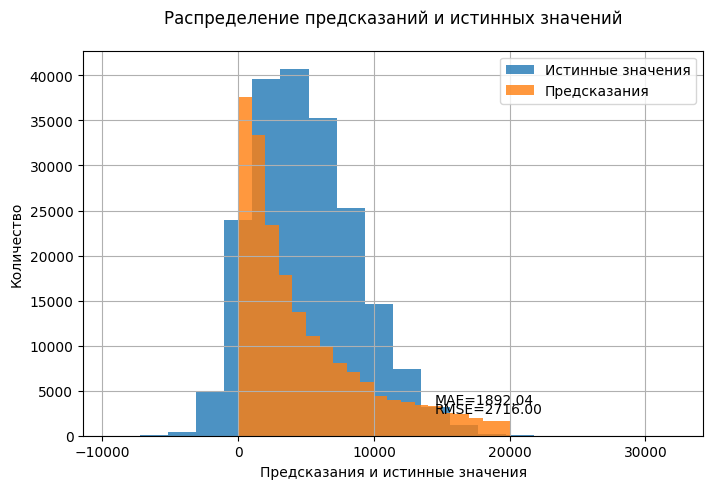

In [89]:
target_predict(target_train, predictions_lr_mc)

#### 3.1.2 На выборке без мультиколлинеарных признаков

In [90]:
%%time

start = time.time()
model_lr_nmc = LinearRegression()
model_lr_nmc.fit(features_nmc_train, target_train)
end = time.time()
t_lr_nmc = round(end-start, 2)

CPU times: user 2.2 s, sys: 189 ms, total: 2.39 s
Wall time: 1.33 s


In [91]:
%%time

start = time.time()
predictions_lr_nmc = model_lr_nmc.predict(features_nmc_train)
end = time.time()
t_lr_nmc_p = round(end-start, 2)

CPU times: user 98.8 ms, sys: 12.8 ms, total: 112 ms
Wall time: 60.8 ms


In [92]:
mae_lr_nmc = mean_absolute_error(target_train, predictions_lr_nmc)
print('MAE модели Линейная Регрессия без мультиколлинеарных признаков:',
      mae_lr_nmc.round(2))

rmse_lr_nmc = rmse(target_train, predictions_lr_nmc)
print('RMSE модели Линейная Регрессия без мультиколлинеарных признаков:', 
      rmse_lr_nmc)

MAE модели Линейная Регрессия без мультиколлинеарных признаков: 2052.55
RMSE модели Линейная Регрессия без мультиколлинеарных признаков: 2903.1


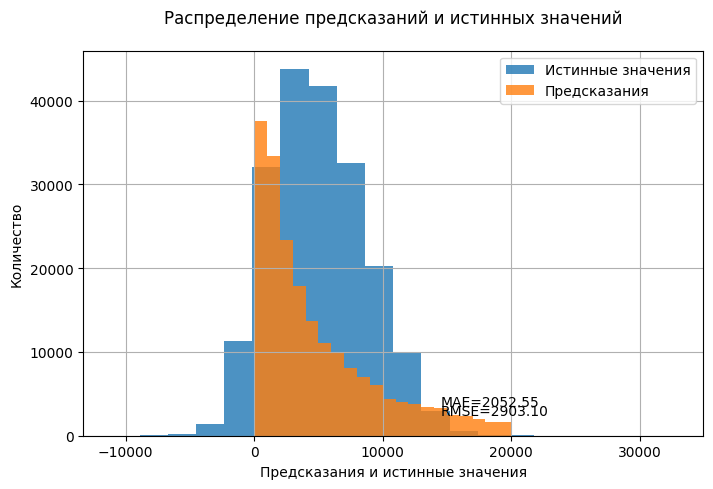

In [93]:
target_predict(target_train, predictions_lr_nmc)

**Вывод по модели линейная регрессия:**
- Модель линейной регрессии с мультиколлинеарными признаками дает MAE равную 1894.09 и RMSE равную 2716.4 - ошибка довольно-таки велика и по графику видно, что модель не перекрывает весь спектр возможных значений;
- Модель линейной регрессии без мультиколлинеарных признаков дает MAE равную 2054.16 и RMSE равную 2903.22 - ошибка стала еще больше, в случае линейной регрессии не требовалось удалять признак model;

### 3.2 Модель  случайного леса

#### 3.2.1 На выборке с мультиколлинеарными признаками

In [94]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 150, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(2, 50, num = 2)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 25, 41, 56, 72, 87, 103, 118, 134, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [95]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'matthews_corrcoef', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'positive_likelihood_ratio', 'neg_negative_likelihood_ratio', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weig

In [ ]:
%%time

rf = RandomForestRegressor(random_state=RANDOM)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid,  
                               cv = 3, 
                               verbose=2,
                               n_iter = 5,
                               random_state=RANDOM, 
                               scoring = 'neg_root_mean_squared_error',
                               n_jobs = -1)
rf_random.fit(features_mc_train, target_train)

In [97]:
rf_random.best_params_

{'n_estimators': 41,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [98]:
start = time.time()
model_rf_mc = RandomForestRegressor(n_estimators=41, criterion='squared_error',
                                 min_samples_split=10, min_samples_leaf=1, 
                                 random_state=RANDOM, bootstrap=True)
model_rf_mc.fit(features_mc_train, target_train)
end = time.time()
t_rf_mc = round(end-start, 2)

In [99]:
%%time

start = time.time()
predictions_rf_mc = model_rf_mc.predict(features_mc_train)
end = time.time()
t_rf_mc_p = round(end-start, 2)

CPU times: user 8.33 s, sys: 903 ms, total: 9.23 s
Wall time: 9.65 s


In [100]:
mae_rf_mc = mean_absolute_error(target_train, predictions_rf_mc)
print('MAE модели Случайного Леса с мультиколлинеарными признаками:',
      mae_rf_mc.round(2))

rmse_rf_mc = rmse(target_train, predictions_rf_mc)
print('RMSE модели Случайного Леса  с мультиколлинеарными признаками:', 
      rmse_rf_mc)

MAE модели Случайного Леса с мультиколлинеарными признаками: 778.04
RMSE модели Случайного Леса  с мультиколлинеарными признаками: 1212.82


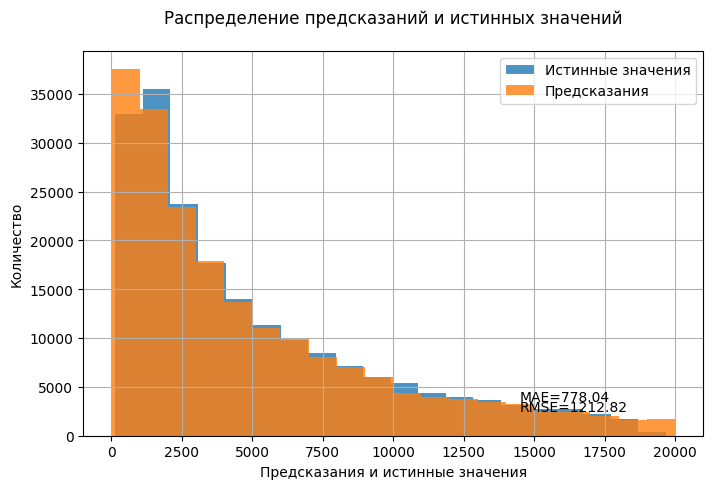

In [101]:
target_predict(target_train, predictions_rf_mc)

#### 3.2.2 На выборке без мультиколлинеарных признаков

In [102]:
%%time

start = time.time()
model_rf_nmc = RandomForestRegressor(n_estimators=41, criterion='squared_error',
                                 min_samples_split=10, min_samples_leaf=1, 
                                 random_state=RANDOM, bootstrap=True)
model_rf_nmc.fit(features_nmc_train, target_train)

end = time.time()
t_rf_nmc = round(end-start, 2)

CPU times: user 1min 48s, sys: 2.26 s, total: 1min 50s
Wall time: 1min 56s


In [103]:
%%time

start = time.time()
predictions_rf_nmc = model_rf_nmc.predict(features_nmc_train)
end = time.time()
t_rf_nmc_p = round(end-start, 2)

CPU times: user 6.36 s, sys: 141 ms, total: 6.5 s
Wall time: 6.89 s


In [104]:
mae_rf_nmc = mean_absolute_error(target_train, predictions_rf_nmc)
print('MAE модели Случайного Леса без мультиколлинеарных признаков:',
      mae_rf_nmc.round(2))

rmse_rf_nmc = rmse(target_train, predictions_rf_nmc)
print('RMSE модели Случайного Леса без мультиколлинеарных признаков:', 
      rmse_rf_nmc)

MAE модели Случайного Леса без мультиколлинеарных признаков: 838.29
RMSE модели Случайного Леса без мультиколлинеарных признаков: 1305.11


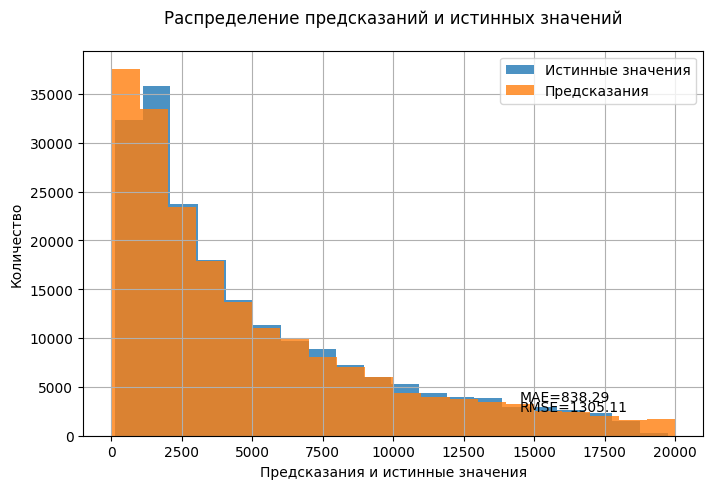

In [105]:
target_predict(target_train, predictions_rf_nmc)

**Вывод по модели случайный лес:**
- При помощи RandomizedSearchCV подобрали следующие гиперпараметры:
  - n_estimators=41; 
  - criterion='mse';
  - min_samples_split=10; 
  - min_samples_leaf=1; 
  - random_state=RANDOM;
  - bootstrap=True
- Модель случайного леса с мультиколлинеарными признаками дает MAE равную 778.04 и RMSE равную 1212.82 - мы достигли заданного показаталя (RMSE меньше 2500). По графику видно, что модель практически полностью перекрывает весь спектр возможных значений;
- Модель линейной регрессии без мультиколлинеарных признаков дает MAE равную 838.29 и RMSE равную 1305.11 - ошибка стала еще больше, в случае случайного леса не требовалось удалять признак model;

### 3.3  Градиентный бустинг LightGBM

#### 3.3.1 На выборке с мультиколлинеарными признаками

In [106]:
%%time

start = time.time()
model_lgbm_mc = lgbm.sklearn.LGBMRegressor(n_estimators=1300,
                                           random_state=RANDOM,
                                           learning_rate=0.2, 
                                           objective='rmse')
model_lgbm_mc.fit(features_mc_train, target_train, 
                  eval_set=(features_mc_test, target_test), 
                  verbose=100)
end = time.time()
t_lgbm_mc = round(end-start, 2)

[100]	valid_0's rmse: 1702.07
[200]	valid_0's rmse: 1667.89
[300]	valid_0's rmse: 1653.47
[400]	valid_0's rmse: 1643.17
[500]	valid_0's rmse: 1636.2
[600]	valid_0's rmse: 1628.36
[700]	valid_0's rmse: 1624.18
[800]	valid_0's rmse: 1622.93
[900]	valid_0's rmse: 1621.07
[1000]	valid_0's rmse: 1620.91
[1100]	valid_0's rmse: 1620.52
[1200]	valid_0's rmse: 1619.65
[1300]	valid_0's rmse: 1620.72
CPU times: user 1min 15s, sys: 6.3 s, total: 1min 21s
Wall time: 36.5 s


In [107]:
%%time

start = time.time()
predictions_lgbm_mc = model_lgbm_mc.predict(features_mc_train)
end = time.time()
t_lgbm_mc_p = round(end-start, 2)

CPU times: user 1min 27s, sys: 2.94 s, total: 1min 30s
Wall time: 38.1 s


In [108]:
mae_lgbm_mc = mean_absolute_error(target_train, predictions_lgbm_mc)
print('MAE модели LightGBM с мультиколлинеарными признаками:',
      mae_lgbm_mc.round(2))

rmse_lgbm_mc = rmse(target_train, predictions_lgbm_mc)
print('RMSE модели LightGBM с мультиколлинеарными признаками:', 
      rmse_lgbm_mc)

MAE модели LightGBM с мультиколлинеарными признаками: 904.29
RMSE модели LightGBM с мультиколлинеарными признаками: 1373.31


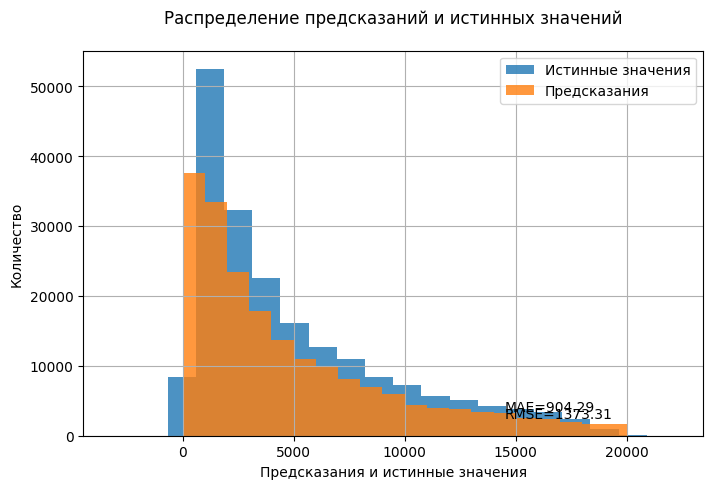

In [109]:
target_predict(target_train, predictions_lgbm_mc)

#### 3.3.2 На выборке без мультиколлинеарных признаков

In [110]:
%%time

start = time.time()
model_lgbm_nmc = lgbm.sklearn.LGBMRegressor(n_estimators=1300,
                                           random_state=RANDOM,
                                           learning_rate=0.2, 
                                           objective='rmse')
model_lgbm_nmc.fit(features_nmc_train, target_train, 
                  eval_set=(features_nmc_test, target_test), 
                  verbose=100)
end = time.time()
t_lgbm_nmc = round(end-start, 2)

[100]	valid_0's rmse: 1743.41
[200]	valid_0's rmse: 1711.77
[300]	valid_0's rmse: 1694.64
[400]	valid_0's rmse: 1685.31
[500]	valid_0's rmse: 1679.41
[600]	valid_0's rmse: 1675.36
[700]	valid_0's rmse: 1671.74
[800]	valid_0's rmse: 1670.77
[900]	valid_0's rmse: 1669.95
[1000]	valid_0's rmse: 1668.73
[1100]	valid_0's rmse: 1667
[1200]	valid_0's rmse: 1667.24
[1300]	valid_0's rmse: 1669.29
CPU times: user 1min 4s, sys: 4.62 s, total: 1min 9s
Wall time: 27.9 s


In [111]:
%%time

start = time.time()
predictions_lgbm_nmc = model_lgbm_nmc.predict(features_nmc_train)
end = time.time()
t_lgbm_nmc_p = round(end-start, 2)

CPU times: user 1min 7s, sys: 1.45 s, total: 1min 9s
Wall time: 26 s


In [112]:
mae_lgbm_nmc = mean_absolute_error(target_train, predictions_lgbm_nmc)
print('MAE модели LightGBM с мультиколлинеарными признаками:',
      mae_lgbm_nmc.round(2))

rmse_lgbm_nmc = rmse(target_train, predictions_lgbm_nmc)
print('RMSE модели LightGBM с мультиколлинеарными признаками:', 
      rmse_lgbm_nmc)

MAE модели LightGBM с мультиколлинеарными признаками: 934.97
RMSE модели LightGBM с мультиколлинеарными признаками: 1416.71


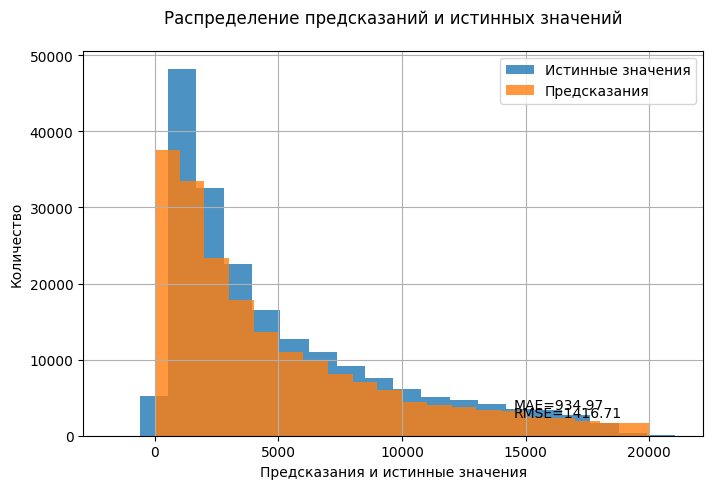

In [113]:
target_predict(target_train, predictions_lgbm_nmc)

**Выводы по модели градиентный бустинг LightGBM:**
- Установили следующие гиперпараметры:
  - n_estimators=1300;
  - random_state=RANDOM;
  - learning_rate=0.2;
  - objective='rmse';
- Модель градиентного бустинга LightGBM с мультиколлинеарными признаками дает MAE равную 904.29 и RMSE равную 1373.31 - мы достигли заданного показаталя (RMSE меньше 2500). По графику видно, что модель не полностью перекрывает весь спектр возможных значений;
- Модель градиентного бустинга LightGBM без мультиколлинеарных признаков дает MAE равную 934.97 и RMSE равную 1416.71 - ошибка стала еще больше, в случае градиентного бустинга LightGBM не требовалось удалять признак model. Но при этом мы видим, что предсказания модели лучше перекрывыают спектр истинных значений;

### Выводы по шагу 3
- Обучили на выборках с мультиколлинеарными признаками и без следующие модели:
  - Линейная регрессия:
    - Модель линейной регрессии с мультиколлинеарными признаками дает MAE равную 1894.09 и RMSE равную 2716.4 - ошибка довольно-таки велика и по графику видно, что модель не перекрывает весь спектр возможных значений;
    - Модель линейной регрессии без мультиколлинеарных признаков дает MAE равную 2054.16 и RMSE равную 2903.22 - ошибка стала еще больше, в случае линейной регрессии не требовалось удалять признак model;
  - Случайный лес:
    - При помощи RandomizedSearchCV подобрали следующие гиперпараметры:
      - n_estimators=41; 
      - criterion='mse';
      - min_samples_split=10; 
      - min_samples_leaf=1; 
      - random_state=12345;
    - Модель случайного леса с мультиколлинеарными признаками дает MAE равную 1042.94 и RMSE равную 1667.37 - мы достигли заданного показаталя (RMSE меньше 2500). По графику видно, что модель практически полностью перекрывает весь спектр возможных значений;
    - Модель линейной регрессии без мультиколлинеарных признаков дает MAE равную 1076.32 и RMSE равную 1708.46 - ошибка стала еще больше, в случае случайного леса не требовалось удалять признак model;
  - Градиентный бустинг LightGBM:
    - Установили следующие гиперпараметры:
      - n_estimators=1200;
      - random_state=12345;
      - learning_rate=0.2;
      - objective='rmse';
    - Модель градиентного бустинга LightGBM с мультиколлинеарными признаками дает MAE равную 1015.04 и RMSE равную 1620.72 - мы достигли заданного показаталя (RMSE меньше 2500). По графику видно, что модель не полностью перекрывает весь спектр возможных значений;
    - Модель градиентного бустинга LightGBM без мультиколлинеарных признаков дает MAE равную 1051.35 и RMSE равную 1667.24 - ошибка стала еще больше, в случае градиентного бустинга LightGBM не требовалось удалять признак model. Но при этом мы видим, что предсказания модели лучше перекрывыают спектр истинных значений;

## 4 Анализ моделей

In [114]:
column = ['MAE модели', 'RMSE модели', 'Скорость обучения, s', 'Скорость предсказания, s']

comp_table = pd.DataFrame(index = ['MAE модели', 'RMSE модели', 
                                   'Скорость обучения, s', 'Скорость предсказания, s'], 
                          columns=['Линейная регрессия с мультиколлинеарными признаками', 
                                   'Линейная регрессия без мультиколлинеарных признаков', 
                                   'Случайный лес с мультиколлинеарными признаками',
                                   'Случайный лес без мультиколлинеарных признаков',
                                   'LightGBM с мультиколлинеарными признаками', 
                                   'LightGBM без мультиколлинеарных признаков'])
comp_table['Линейная регрессия с мультиколлинеарными признаками'] = mae_lr_mc, rmse_lr_mc, t_lr_mc, t_lr_mc_p
comp_table['Линейная регрессия без мультиколлинеарных признаков'] = mae_lr_nmc, rmse_lr_nmc, t_lr_nmc, t_lr_nmc_p
comp_table['Случайный лес с мультиколлинеарными признаками'] = mae_rf_mc, rmse_rf_mc, t_rf_mc, t_rf_mc_p
comp_table['Случайный лес без мультиколлинеарных признаков'] = mae_rf_nmc, rmse_rf_nmc, t_rf_nmc, t_rf_nmc_p
comp_table['LightGBM с мультиколлинеарными признаками'] = mae_lgbm_mc, rmse_lgbm_mc, t_lgbm_mc, t_lgbm_mc_p
comp_table['LightGBM без мультиколлинеарных признаков'] = mae_lgbm_nmc, rmse_lgbm_nmc, t_lgbm_nmc, t_lgbm_nmc_p


comp_table.T.style.highlight_min(color='yellowgreen', subset=column).highlight_null().highlight_max(color='coral', subset=column)

,MAE модели,RMSE модели,"Скорость обучения, s","Скорость предсказания, s"
Линейная регрессия с мультиколлинеарными признаками,1892.036110,2716.000000,10.160000,0.580000
Линейная регрессия без мультиколлинеарных признаков,2052.547654,2903.100000,1.330000,0.060000
Случайный лес с мультиколлинеарными признаками,778.035400,1212.820000,381.570000,9.650000
Случайный лес без мультиколлинеарных признаков,838.285253,1305.110000,116.180000,6.890000
LightGBM с мультиколлинеарными признаками,904.289981,1373.310000,36.460000,38.080000
LightGBM без мультиколлинеарных признаков,934.965866,1416.710000,27.860000,25.980000


По таблице видно:
- Самой быстрой моделью является линейная регрессия, при этом у модели линейной регрессии худшие метрики MAE и RMSE;
- Лучшие метрики MAE (778.04) и RMSE (1212.82) у модели случайного леса с мультиколлинеарными признаками, но при этом самая долгая скорость обучения (192 секунды);
- Модель градиентного бустинга LightGBM с мультиколлинеарными признаками имеет довольно-таки высокую скорость обучения (9.16 секунды), при этом скорость предсказания равна 8.72 секунды, что немногим больше скорости предсказания случайного леса с мультиколлинеарными признаками (4.57 секунды). Метрики MAE и RMSE равны 904.29 и 1373.31 соответственно;
- Во всех случаях не требовалось удалять мультиколлинеарные признаки, так как качество предсказаний ухудшилось (признак model значим для таргета);
- В данном проекте важна скорость обучения и предесказания, а также необходимо было достигнуть целевого значения метрики RMSE меньше 2500, поэтому учитывая оба фактора, могу порекомендовать заказчу модель градиентного бустинга LightGBM;

#### 4.1 Проверим качество модели LightGBM на тестовой выборке

In [115]:
%%time

start = time.time()
predictions_lgbm_mc_test = model_lgbm_mc.predict(features_mc_test)
end = time.time()
t_lgbm_mc_p_test = round(end-start, 2)

CPU times: user 21.8 s, sys: 759 ms, total: 22.6 s
Wall time: 9.72 s


In [116]:
mae_lgbm_mc_test = mean_absolute_error(target_test, predictions_lgbm_mc_test)
print('MAE модели LightGBM с мультиколлинеарными признаками на тестовой выборке:',
      mae_lgbm_mc_test.round(2))

rmse_lgbm_mc_test = rmse(target_test, predictions_lgbm_mc_test)
print('RMSE модели LightGBM с мультиколлинеарными признаками на тестовой выборке:', 
      rmse_lgbm_mc_test)

MAE модели LightGBM с мультиколлинеарными признаками на тестовой выборке: 1015.04
RMSE модели LightGBM с мультиколлинеарными признаками на тестовой выборке: 1620.72


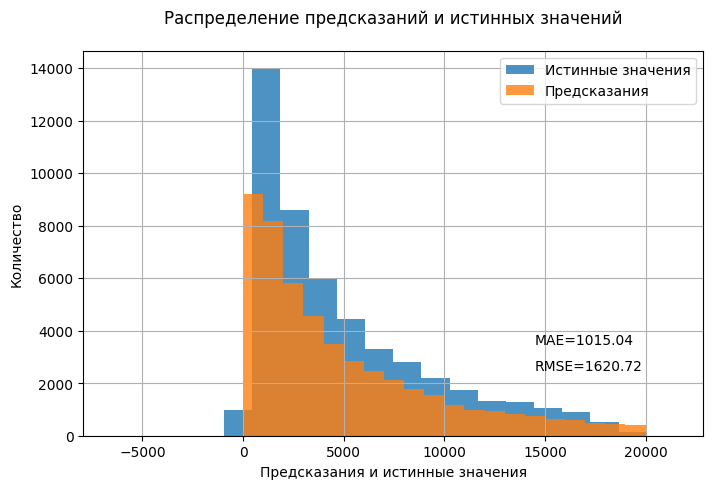

In [117]:
target_predict(target_test, predictions_lgbm_mc_test)

#### 4.2 Проверим качество модели Случайный Лес на тестовой выборке

Данная проверка не требуется, но так как метрики были лучше у модели случайного леса, то я считаю целесообразным провести проверку на тесте.

In [118]:
%%time

start = time.time()
predictions_rf_mc_test = model_rf_mc.predict(features_mc_test)
end = time.time()
t_rf_mc_p_test = round(end-start, 2)

CPU times: user 1.99 s, sys: 109 ms, total: 2.1 s
Wall time: 2.17 s


In [119]:
mae_rf_mc_test = mean_absolute_error(target_test, predictions_rf_mc_test)
print('MAE модели Случайного Леса с мультиколлинеарными признаками:',
      mae_rf_mc_test.round(2))

rmse_rf_mc_test = rmse(target_test, predictions_rf_mc_test)
print('RMSE модели Случайного Леса  с мультиколлинеарными признаками:', 
      rmse_rf_mc_test)

MAE модели Случайного Леса с мультиколлинеарными признаками: 1042.94
RMSE модели Случайного Леса  с мультиколлинеарными признаками: 1667.37


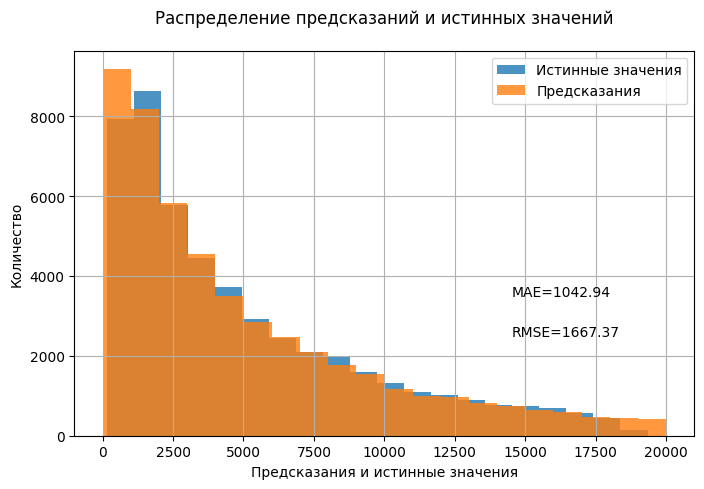

In [120]:
target_predict(target_test, predictions_rf_mc_test)

#### 4.3 Сравним результаты

In [121]:
column = ['MAE модели на тестовой выборке', 'RMSE модели на тестовой выборке', 
          'Скорость обучения, s', 'Скорость предсказания, s']

comp_table = pd.DataFrame(index = ['MAE модели на тестовой выборке', 'RMSE модели на тестовой выборке', 
                                   'Скорость обучения, s', 'Скорость предсказания, s'], 
                          columns=['Случайный лес с мультиколлинеарными признаками',
                                   'LightGBM с мультиколлинеарными признаками'])

comp_table['Случайный лес с мультиколлинеарными признаками'] = mae_rf_mc_test, rmse_rf_mc_test, t_rf_mc, t_rf_mc_p_test
comp_table['LightGBM с мультиколлинеарными признаками'] = mae_lgbm_mc_test, rmse_lgbm_mc_test, t_lgbm_mc, t_lgbm_mc_p_test


comp_table.T.style.highlight_min(color='yellowgreen', subset=column).highlight_null().highlight_max(color='coral', subset=column)

,MAE модели на тестовой выборке,RMSE модели на тестовой выборке,"Скорость обучения, s","Скорость предсказания, s"
Случайный лес с мультиколлинеарными признаками,1042.938652,1667.370000,381.570000,2.170000
LightGBM с мультиколлинеарными признаками,1015.040324,1620.720000,36.460000,9.720000


На тестовой выборке модель случайного леса показала худшие результаты практически по всем параметрам кроме скорости предсказания - 1.33 секунды. Низкая скорость обучения - 187.3 секунд. У модели LightGBM скорость предсказания вдвое ниже (1.88 секунды), но это незначительные различия.
По результатам проверки моделей на тестовой выборке смело можно рекомендовать заказчику модель градиентного бустинга LightGBM:
- MAE модели равно 1015.04;
- RMSE модели равно 1620.72;
- Скорость обучения равна 9.6 секунды;
- Скорость предсказания равна 1.88 секунды;

------

### Выводы по шагу 4
- Самой быстрой моделью является линейная регрессия, при этом у модели линейной регрессии худшие метрики MAE и RMSE;
- Лучшие метрики MAE (778.04) и RMSE (1212.82) у модели случайного леса с мультиколлинеарными признаками, но при этом самая долгая скорость обучения (192 секунды);
- Модель градиентного бустинга LightGBM с мультиколлинеарными признаками имеет довольно-таки высокую скорость обучения (9.16 секунды), при этом скорость предсказания равна 8.72 секунды, что немногим больше скорости предсказания случайного леса с мультиколлинеарными признаками (4.85 секунды). Метрики MAE и RMSE равны 904.29 и 1373.31 соответственно;
- Во всех случаях не требовалось удалять мультиколлинеарные признаки, так как качество предсказаний ухудшилось (признак model значим для таргета);
- В данном проекте важна скорость обучения и предесказания, а также необходимо было достигнуть целевого значения метрики RMSE меньше 2500, поэтому учитывая оба фактора, могу порекомендовать заказчу модель градиентного бустинга LightGBM;
- На тестовой выборке модель случайного леса показала худшие результаты практически по всем параметрам кроме скорости предсказания - 1.31 секунды. Низкая скорость обучения - 186 секундs;
- У модели LightGBM скорость предсказания вдвое ниже (2.32 секунды), но это незначительные различия;
- По результатам проверки моделей на тестовой выборке смело можно рекомендовать заказчику модель градиентного бустинга LightGBM:
  - MAE модели равно 1015.04;
  - RMSE модели равно 1620.72;
  - Скорость обучения равна 9.16 секунды;
  - Скорость предсказания равна 2.32 секунды;

## Общий вывод
- На первом шаге:
  - Выяснили, что перед нами стоит задача регрессии: определение рыночной стоимости автомобиля (таргет price);
  - Удалили признаки, не влияющие на прогнозирование цены авто:
    - date_crawled — дата скачивания анкеты из базы
    - date_created — дата создания анкеты
    - number_of_pictures — количество фотографий автомобиля
    - postal_code — почтовый индекс владельца анкеты (пользователя)
    - last_seen — дата последней активности пользователя
  - Сделали следующие выводы по признакам:
    - Цена:
      - Минимальная цена автомобиля - 0 евро, что равносильно пропуску;
      - Максимальная цена - 20000 евро;
      - Медианная цена - 2700 евро;
      - Средняя цена - 4417 евро, что означает, что есть какие-то дорогие автомобили, влияющие на характеристику среднего;
    - Год регистрации автомобиля:
      - Есть аномалии:
        - Минимальный год регистрации - 1000;
        - Максимальный год - 9999;
      - Среднее (2004) и медианное (2003) значения практически совпадают;
      - 75% автомобилей зарегистрированы до 2008 года;
    - Мощность:
      - Минимальная мощность - 0 л.с. (равносильно пропуску);
      - Средняя мощность - 110 л.с.;
      - 50% автомобилей имеют мощность до 105 л.с. (среднее и медиана практически равны);
      - Максимальная мощность - 20000 л.с. (аномалия);
    - Пробег:
      - Минимальный пробег - 5000 км;
      - Максимальный - 150000 км;
      - Средний пробег - 128211 км;
      - Медианный - 150000 км;
    - Месяц регистрации автомобиля:
      - Минимальный месяц регистрации - 0 (аномалия, равносильно пропуску);
      - Максимальный месяц регистрации - 12 (без аномалий);
      - В целом распределение выглядит нормальным - 50%/в среднем автомобили зарегистрированы в первой половине года (необходимо посмотреть на распределение);
    - Количество фотографий автомобиля:
      - Фотографии отсутствуют во всех объявлениях, признак неинформативен;
  - Обнаружили пропуски в данных:
    - Больше всего пропусков в столбце repaired - 20% (71154 значения);
    - Далее идет столбец vehicle_type - 11% (37490 значений);
    - Столбец fuel_type - 9% (32895);
    - Столбцы gearbox (19833) и model (19705) по 6%;
    - В остальных столбцах пропуски отсутствуют;
  - Проверили корреляцию признаков при помощи коэффициента 𝜙k:
    - Увидели следующие зависимости:
      - Между маркой автомобиля и моделью автомобиля - 0.998;
      - Между типом автомобильного кузова и моделью автомобиля - 0.917;
      - Между маркой автомобиля и типом коробки передач - 0.647;
      - Между типом автомобильного кузова и маркой автомобиля - 0.633;
      - Между моделью автомобиля и ценой - 0.579;
      - Между моделью автомобиля и типом топлива - 0.555;
      - Между маркой автомобиля и типом коробки передач  - 0.521;
      - Много зависимостей с коэффициентом 𝜙k около 0.5;
      - Проверили зависимость таргета от фичей, выяснили:
        - Прослеживается связь между моделью автомобиля и ценой (model vs price) - 0.58;
        - Есть слабая связь между:
          - Была ли машина в ремонте или нет и ценой (repaired vs price) - 0.38;
          - Маркой машины и ценой (brand vs price) - 0.36;
          - Коробкой передач и ценой (gearbox vs price) - 0.32;
          - Пробегом и ценой (kilometer vs price) - 0.31;
          - Типом кузова и ценой (vehicle_type vs price) - 0.27;
          - Типом топлива и ценой (fuel_type vs price) - 0.26;
        - Наличие корреляции между фичей и таргетом является плюсом для того, чтобы модель хорошо обучалась;
    - Выяснили, что столкнулись с проблемой мультиколлинеарности признаков. Большинство методов устранения мультиколлинеарности предполагает исключение порождающих её признаков. В следующих шагах проверим, улучшится ли качество модели, если удалить один из признаков, то есть проверим модели с мультиколлинеарными признаками и без;
  - Подробно рассмотрели признаки, устранили пропуски и аномалии, сделали следующие выводы:
    - Выводы по типу кузова vehicle_type:
      - Популярность типов кузова:
        - Популярнее всего тип кузова sedan - 90870 значений (27%);
        - На втором месте small - 79059 значений (23.5%);
        - На третьем месте wagon - 64683 значений (19.2%);
        - Далее следуют bus (8.49%), convertible (5.95%), coupe (4.76%) и suv (3.54%);
      - Мы определили, что коэффициент корреляции 𝜙k между типом кузова и ценой автомобиля равен 0,27, можем проследить следующие зависимости:
        - Автомобили с типом кузова small:
          - Чаще всего стоят до 1199 евро включительно - 31836 значений; 
          - От 1199 до 2899 евро включительно - 22459 значений;
          - От 2899 до 6500 евро включительно - 23932 значений;
          - От 2899 до 6500 евро включительно - 16749 значений;
          - Реже всего от 6500 до 20000 евро включительно - 8015 значений; 
        - Автомобили с типом кузова sedan:
          - Чаще всего стоят от 6500 до 20000 евро включительно - 24210 значений; 
          - От 1199 до 2899 евро включительно - 23932 значений;
          - От 2899 до 6500 евро включительно - 22834 значений;
          - Реже всего от 1199 до 2899 евро включительно - 19894 значений;
        - Автомобили с типом кузова wagon чаще всего стоят до 2000 евро - 23621 значений и от 2000 до 4000 евро - 13793 значений; 
        - В целом цены распределены довольно-таки равномерно;
      - У нас 22122 строки (6.58%) с пропусками в типе кузова. Определить тип кузова мы никак не сможем, поэтому заполнили пропуски значением моды по модели автомобиля, так как коэффициент корреляции 𝜙k равен 0.917:
      - После заполнения осталось 6828 значений с пропусками. Можем сделать вывод, что для некоторых моделей авто нет моды, поэтому и нет заполнения. Коэффициент корреляции 𝜙k между типом кузова и маркой автомобиля равен 0.633. Заполнили оставшиеся пропуски модой по марке автомобиля;
    - Выводы по типу коробки передач gearbox:
      - Популярнее всего механическая коробка передач manual 78%;
      - На долю автомата auto приходится 19,4%;
      - Для механики цена по группам распределена довольно-таки равномерно;
      - Для автомата наиболее часто встречаемой группой является цена от 6500 до 20000 евро (28446 значений);
      - Пропуски в данных составляют 2.66% (8954 значения), заполнили модой по модели автомобиля, так как коэффициент корреляции 𝜙k равен 0.647 и после оставшиеся пропуски заполнили модой по марке автомобиля (коэффициент корреляции 𝜙k равен 0.521);
    - Выводы по модели автомобимля model:
      - Пропуски в данных составляли 6% (19705 значений), заполнили пропуски модой по модели автомобиля; 
    - Выводы по типу топлива fuel_type:
      - Объединили значения petrol и gasoline, так как это обозначение бензина в разных странах;
      - Чаще всего используют бензиновые типы двигателей - 92.6%;
      - Далее идет с большим отрывом смесь пропана и бутана lpg - 1.56%;
      - У других типов топлива совсем незначительные цифры (видимо, причина в том, что данные за 2016 год и много старых автомобилей, ставку на экологичность еще не делали);
      - Цена автомобиля в зависимости от типа топлива распределена равномерно, видно лишь, что стоимость гибридных автомобилей чаще всего составляет выше 6500 евро;
      - Пропуски составляли 5.51% (18540 значений), заполнили модой по модели автомобиля (коэффициент phik равен 0.555);
    - Выводы по ремонту автомобилей:
      - Чаще всего автомобиль не был в ремонте -  73.1%;
      - Был в ремонте в 10.6% случаев;
      - Зависимость цены от факта ремонта автомобиля:
        - Цена распределена равномерно среди автомобилей, не бывших в ремонте;
        - Автомобили, бывшие в ремонте чаще всего стоят до 1199 евро и до 2899 евро;
      - Пропуски составляли 16.4% (55104 значения). Предположили, что раз факт ремонта не указан, то его не было. Заполнили пропуски значением no;
    - Выводы по году регистрации автомобиля:
       - В годе регистрации автомобиля были видны аномалии: 
         - Удалили автомобили с годом регистрации позже 2016, так как мы имеем данные за 2016 год, то год регистрации не может быть больше 2016.
         - Удалили также все автомобили старше 1970 года, так как:
           - Первый в мире серийный автомобиль появился в 1885 году, все, что раньше - аномалии; 
           - По ГОСТ от 01.03.2020 раритетным является автомобиль, с момента производства которого прошло больше 30 лет. Цену раритетного автомобиля очень сложно предсказать;
    - Выводы по мощности автомобиля в лс:
      - В данных было много аномалий:
        - Удалили автомобили мощностью более 1000 л.с (275 значений), так как самым мощным автомобилем в мире является Dagger GT - 2028 лс. У нас представлены легковые автомобили и автобусы. Самым мощным автобусом является Mercedes-Benz Citaro G - до 480 лс. Цену тюнингованных автомобилей также сложно предсказать.
        - Заменили значения мощности равное 0 (35934 значений) медианой по модели;
    - Выводы по пробегу автомобиля в километрах:
      - Аномалий не было выявлено. Данные выглядят немного синтетическими, т.к. пики на значениях, кратных 10 тыс. Возможно, при внесении данных их округляли;
    - Выводы по марке автомобиля:
      - Наиболее популярной маркой автомобиля является Volkswagen - 21.6% (64300);
      - На втором месте opel - 11% (32658) и bmw - 10.9% (32508);
      - Далее идет mercedes_benz - 9.24% (27451);
      - Audi - 8.7% (25856);
      - Можно сделать вывод, что наиболее популярными являются немецкие автомобили;
    - Выводы по цене автомобиля в евро:
      - Удалили автомобили с ценой равной 0 (6374 значения), так как price является целевым признаком (таргетом) и заполнение может быть некорректным и может отрицательно повлиять на прогноз модели;
  - Обнаружили 49683 явных дубликата и удалили их;
- На втором шаге:
  - Решили, что будем рассматривать модели как на данных с мультиколлинеарными признаками, так и без. Во втором случае удалили признак model, так как он имел наибольшее количество корреляций с другими признаками (коэффициент 𝜙k);
  - Разделили данные на обучающую (80%) и тестовую выборки (20%);
  - Закодировали категориальные признаки при помощи OHE из sklearn;
  - Промасштабировали численные признаки при помощи StandardScaler;
- На третьем шаге:
  - Обучили на выборках с мультиколлинеарными признаками и без следующие модели:
    - Линейная регрессия:
      - Модель линейной регрессии с мультиколлинеарными признаками дает MAE равную 1894.09 и RMSE равную 2716.4 - ошибка довольно-таки велика и по графику видно, что модель не перекрывает весь спектр возможных значений;
      - Модель линейной регрессии без мультиколлинеарных признаков дает MAE равную 2054.16 и RMSE равную 2903.22 - ошибка стала еще больше, в случае линейной регрессии не требовалось удалять признак model;
    - Случайный лес:
      - При помощи RandomizedSearchCV подобрали следующие гиперпараметры:
        - n_estimators=41; 
        - criterion='mse';
        - min_samples_split=10; 
        - min_samples_leaf=1; 
        - random_state=12345;
      - Модель случайного леса с мультиколлинеарными признаками дает MAE равную 1042.94 и RMSE равную 1667.37 - мы достигли заданного показаталя (RMSE меньше 2500). По графику видно, что модель практически полностью перекрывает весь спектр возможных значений;
      - Модель линейной регрессии без мультиколлинеарных признаков дает MAE равную 1076.32 и RMSE равную 1708.46 - ошибка стала еще больше, в случае случайного леса не требовалось удалять признак model;
    - Градиентный бустинг LightGBM:
      - Установили следующие гиперпараметры:
        - n_estimators=1200;
        - random_state=12345;
        - learning_rate=0.2;
        - objective='rmse';
      - Модель градиентного бустинга LightGBM с мультиколлинеарными признаками дает MAE равную 1015.04 и RMSE равную 1620.72 - мы достигли заданного показаталя (RMSE меньше 2500). По графику видно, что модель не полностью перекрывает весь спектр возможных значений;
      - Модель градиентного бустинга LightGBM без мультиколлинеарных признаков дает MAE равную 1051.35 и RMSE равную 1667.24 - ошибка стала еще больше, в случае градиентного бустинга LightGBM не требовалось удалять признак model. Но при этом мы видим, что предсказания модели лучше перекрывыают спектр истинных значений;
- На четвертом шаге установили:
  - Самой быстрой моделью является линейная регрессия, при этом у модели линейной регрессии худшие метрики MAE и RMSE;
  - Лучшие метрики MAE (778.04) и RMSE (1212.82) у модели случайного леса с мультиколлинеарными признаками, но при этом самая долгая скорость обучения (192 секунды);
  - Модель градиентного бустинга LightGBM с мультиколлинеарными признаками имеет довольно-таки высокую скорость обучения (9.16 секунды), при этом скорость предсказания равна 8.72 секунды, что немногим больше скорости предсказания случайного леса с мультиколлинеарными признаками (4.85 секунды). Метрики MAE и RMSE равны 904.29 и 1373.31 соответственно;
  - Во всех случаях не требовалось удалять мультиколлинеарные признаки, так как качество предсказаний ухудшилось (признак model значим для таргета);
  - В данном проекте важна скорость обучения и предесказания, а также необходимо было достигнуть целевого значения метрики RMSE меньше 2500, поэтому учитывая оба фактора, могу порекомендовать заказчу модель градиентного бустинга LightGBM;
  - На тестовой выборке модель случайного леса показала худшие результаты практически по всем параметрам кроме скорости предсказания - 1.31 секунды. Низкая скорость обучения - 186 секунд;
  - У модели LightGBM скорость предсказания вдвое ниже (2.32 секунды), но это незначительные различия;
  - По результатам проверки моделей на тестовой выборке смело можно рекомендовать заказчику модель градиентного бустинга LightGBM:
    - MAE модели равно 1015.04;
    - RMSE модели равно 1620.72;
    - Скорость обучения равна 9.16 секунды;
    - Скорость предсказания равна 2.32 секунды.